# download useful CTCF tracks first ...

In [241]:
# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/chip_seq/CTCF/hff/results/bwa/mergedLibrary/bigwig/HFFC6_CTCF_*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/chip_seq/CTCF/esc/results/bwa/mergedLibrary/bigwig/hESC_CTCF_*.bigWig ./bigwigs/

# # ESC and HFF atac-seq from Betul ...
# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/atac_seq/narrowpeaks/results/bwa/mergedReplicate/bigwig/*.bigWig ./bigwigs/

# # CTCF Cut N Run processed using ATAC-seq pipeline bigwig
# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/results_CTCF_atacseq_pipeline/bwa/mergedReplicate/bigwig/*_CTCF.mRp.clN.bigWig ./bigwigs/

# # HFF CTCF and SMC1 Cut N Tag
# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_tag/results/bwa/mergedReplicate/bigwig/*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/hESC_H3K4me3/results__igg_narrowpeak/bwa/mergedLibrary/bigwig/*_H3K4me3_*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/hESC_H3K27ac/results__igg_narrowpeak/bwa/mergedLibrary/bigwig/*_H3K27ac_*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/HFFc6_H3K4me3/results_narrowpeak__igg/bwa/mergedLibrary/bigwig/HFFc6_H3K4me3_*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/HFFc6_H3K27ac/results__igg_narrow/bwa/mergedLibrary/bigwig/HFFc6_H3K27ac_*.bigWig ./bigwigs/

# # cut_and_run/hESC_H3K27me3/results_narrowpeak/bwa/mergedLibrary/bigwig/
# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/hESC_H3K27me3/results_narrowpeak/bwa/mergedLibrary/bigwig/*_H3K27me3_*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/cut_and_run/HFFc6_H3K27me3/results_narrowpeak/bwa/mergedLibrary/bigwig/*_H3K27me3_*.bigWig ./bigwigs/

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/chip_seq/yy1/*.bigWig ./bigwigs/


# ! mv bigwigs/ENCFF043CXM.bigWig bigwigs/H1-YY1-1.bigWig
# ! mv bigwigs/ENCFF170XRZ.bigWig bigwigs/H1-YY1-2.bigWig
# ! mv bigwigs/ENCFF371JOS.bigWig bigwigs/H1-YY1-3.bigWig
# ! mv bigwigs/ENCFF406PYH.bigWig bigwigs/H1-YY1-4.bigWig
# ! mv bigwigs/ENCFF515UYM.bigWig bigwigs/H1-YY1-5.bigWig
# ! mv bigwigs/ENCFF609AFO.bigWig bigwigs/H1-YY1-6.bigWig

# ! scp newhpc:/pi/job.dekker-umw/home/betul.akgoloksuz-umw/chip_seq/pol2/*.bigWig ./bigwigs/

In [242]:
import pandas as pd
import bioframe
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
import bbi


In [243]:
def get_stack(bigwig_path, df, kind="start", flank=5000, nbins=200, chrom_col="chrom", start_col="start", end_col="end"):
    """
    extract stackups ...
    """
    if kind=="start":
        _start = df.eval(f"({start_col}) - {flank}")
        _end = df.eval(f"({start_col}) + {flank}")
    elif kind=="end":
        _start = df.eval(f"({end_col}) - {flank}")
        _end = df.eval(f"({end_col}) + {flank}")
    elif kind=="mid":
        _start = df.eval(f"({end_col}+{start_col})//2 - {flank}")
        _end = df.eval(f"({end_col}+{start_col})//2 + {flank}")
    else:
        raise("kind can only be start,end or mid")

    return bbi.stackup(
        bigwig_path,
        df[chrom_col],
        _start,
        _end,
        bins=nbins,
    )

#########################
#
#  stackup plotting functions ...
#
##########################

def _same_val(iterable_dict, func, return_val=True):
    """
    helper func checking if all values in 
    [func(elem) for elem in iterable_dict] are
    identical ...
    """
    _iter = iter(iterable_dict)
    _k = next(_iter)
    the_value = func(_k)
    # now check all remaining values ...
    if return_val:
        return the_value, all( func(_k) == the_value for _k in _iter )
    else:
        return all( func(_k) == the_value for _k in _iter )


def _get_hms_shape(hms_dict):
    """
    make sure heatmap-dicts are good for plotting ...
    i.e. they have the same length, width ? etc

    return number of stacks and the shape ...
    """
    the_shape, _shape_is_same = _same_val(hms_dict, lambda k: hms_dict[k].shape)
    if not _shape_is_same:
         raise ValueError('not all stacks have same shape !')
    #
    hm_height, hm_width = the_shape
    return len(hms_dict), hm_height, hm_width


def _get_hms_nested_shape(hms_dict_dict):
    """
    inspect a nested dictionary
    make sure heatmap-dicts are good for plotting ...
    i.e. they have the same length inside a group,
    they have the same width (*all*)
    number of stack per group is the same!
    ...

    return a bunch of info on the nested dict of stacks:
     - number of groups
     - stack samples per group (should be the same across groups)
     - heights of stacks per group (should be the same within each group)
     - stack width - should be the same across all groups/stacks
    """
    #
    num_groups = len(hms_dict_dict)
    group_hm_heights = {}
    group_hm_widths = {}
    group_amount = {}
    group_sample_keys = {}
    #
    for group_k, hms_dict in hms_dict_dict.items():
        # make sure shape of stackup in a group is identical:
        try:
            num_stacks, height, width = _get_hms_shape(hms_dict)
        except ValueError:
            raise ValueError(f'not all stacks in {group_k} have the same shape !')
        # accumulate heights, widths and amount per group ...
        group_hm_heights[group_k] = height
        group_hm_widths[group_k] = width
        group_amount[group_k] = num_stacks
        group_sample_keys[group_k] = list(hms_dict)
    # make sure widths are the same across groups:
    the_width, _width_is_same = _same_val(group_hm_widths, lambda k: group_hm_widths[k])
    if not _width_is_same:
         raise ValueError(f'not all groups of stacks have the same width !')
    # make sure amount of stacks is the same across groups:
    num_stacks_per_group, _amount_is_same = _same_val(group_amount, lambda k: group_amount[k])
    if not _amount_is_same:
         raise ValueError(f'not all groups have the same amount of stacks in them !')
    # make sure stacks (their sample keys) are the same across groups:
    stack_samples, _samples_are_same = _same_val(group_sample_keys, lambda k: group_sample_keys[k])
    if not _samples_are_same:
         raise ValueError(f'not all groups have the same stack samples !')
    # returning
    return num_groups, stack_samples, group_hm_heights, the_width


def _fillmissing_hms(hms_dict, how="col mean"):
    """
    modify heatmaps in the hms_dict by filling
    out the missing values ...

    there should be option on the fill values
    e.g. average from rows, average from columns
    a fixed value
    smth else ?
    how:
        "row mean"
        "col mean"
        float
    """
    hms_dict_filled = {}
    for k, hm in hms_dict.items():
            missing = ~np.isfinite(hm)
            if how == "col mean":
                mu = np.nanmean(hm, axis=0, keepdims=True)
            elif how == "row mean":
                mu = np.nanmean(hm, axis=1, keepdims=True)
            else:
                mu = float(how)  # should be inside try
            hms_dict_filled[k] = np.where(missing, mu, hm)
    return hms_dict_filled


def _get_profiles(hms_dict, scales):
    """
    for each stackup in the hms_dict generate an
    average profile ...
    """
    profile_hm = {}
    for k, hm in hms_dict.items():
        _scale = scales[k]
        if _scale == "log":
            profile_hm[k] = np.nanmean(hm, axis=0)
        else:
            profile_hm[k] = np.nanmean(hm, axis=0)
    # returning
    return profile_hm


def _get_norms(scales, vlims):
    """
    given scales and vlims - return norms !
    """
    norms = {}
    for k, scale in scales.items():
        # try to extract vmin , vmax ...
        try:
            vmin, vmax = vlims[k]
        except Exception:
            vmin, vmax = None, None
        # depending on scale ...
        if scale == "log":
            norms[k] = mpl.colors.LogNorm(vmin, vmax)
        else:
            norms[k] = mpl.colors.Normalize(vmin, vmax)
    # returning ...
    return norms


def plot_stackups_sets(
    num_extra_plots,
    hms_dict_dict,  # heatmaps dict, that controls the order, the amount etc etc ...
    scales,
    vlims,
    titles,
    cmaps,
    binsizes,
    fillmissing=False,
    len_per_thousand=1.2,
    width_per_stack=3.5,
    extra_height=3.0,  # height that goes toward the profile and colorbar
    delta_h=.5,  # fixed distance between axes (vertically)
    delta_w=.2,  # fixed distance between axes (horizontally)
    # **plot_kwargs,
    fig_fontsize=25,
    **imshow_kwargs,
):
    """
    plot a buch of stackups ...
    """
    # rewrite everyhting assuming hms_dict_dict is a dict of stackup groups !
    # groups are plotted on top of each other ...

    if num_extra_plots:
        num_extra_plots = int(num_extra_plots)
    else:
        num_extra_plots = 0

    # inspect provided stacks and define figure with all of the panels ...
    num_stackup_groups, stackup_samples, stackup_group_heights, stack_width = _get_hms_nested_shape(hms_dict_dict)
    total_stack_height = sum(stackup_group_heights.values())
    num_cols = len(stackup_samples) + num_extra_plots
    stackup_height = total_stack_height*len_per_thousand / 1_000
    fig_height = stackup_height + extra_height
    fig_width = width_per_stack*num_cols
    # parameterize the hell out of it ...
    num_axes_vert = num_stackup_groups + 2  # + 2 is for average profile and a colorbar
    num_axes_horz = num_cols
    full_fig_width = fig_width + (num_axes_horz + 1)*delta_w
    full_fig_height = fig_height + (num_axes_vert + 1)*delta_h
    fig = plt.figure(
        figsize=(full_fig_width, full_fig_height),
        facecolor="white",
        layout="none",
    )
    gs = fig.add_gridspec(
        num_stackup_groups+2,
        num_cols,  # widsth ration are equal by default ...
        height_ratios = [
            0.95*extra_height,
            *[(_gh/total_stack_height)*stackup_height for _gh in stackup_group_heights.values()],
            0.05*extra_height,
        ],
        # horizontal spacings ...
        # left, right as a fraction of overall figure width
        left = delta_w/full_fig_width,
        right = 1. - delta_w/full_fig_width,
        # inter-axes spacing as a fraction of average axes height ...
        hspace = delta_h*num_axes_vert/fig_height,
        # vertical spacings ...
        # top, bottom as a fraction of overall figure height
        top = 1. - delta_h/full_fig_height,
        bottom = delta_h/full_fig_height,
        # inter-axes spacing as a fraction of average axes width ...
        wspace = delta_w*num_axes_horz/fig_width,
    )

    ##############
    ax_profile = {}
    ax_stackup = {}
    ax_xtra = []
    ax_cbar = {}
    # define nest dict of axes ...
    for jdx, sample in enumerate(stackup_samples):
        ax_profile[sample] = fig.add_subplot(gs[0, jdx])
        ax_cbar[sample] = fig.add_subplot(gs[-1, jdx])
        ax_stackup[sample] = {}
        for idx, group_k in enumerate(hms_dict_dict):
            ax_stackup[sample][group_k] = fig.add_subplot(gs[idx+1,jdx])
    # provide extra axes at the end ...
    for jdx in range(len(stackup_samples), num_cols):
        ax_xtra.append([fig.add_subplot(gs[_i+1,jdx]) for _i in range(num_stackup_groups)])

    # fill missing if needed and calculate profiles (per group) ...
    hms_dict_dict_copy = {}
    profile_hm = {}
    for group_k, hms_dict in hms_dict_dict.items():
        hms_dict_dict_copy[group_k] = _fillmissing_hms(hms_dict, how="col mean") if fillmissing else hms_dict
        # use modified stacks to calculate profiles ...
        profile_hm[group_k] = _get_profiles(hms_dict_dict_copy[group_k], scales)
    # replace hms_dict_dict with the updated copy ...
    hms_dict_dict = hms_dict_dict_copy
    # get norms - they are just per sample - regardless of the group ...
    norms = _get_norms(scales, vlims)

    last_group_k = list(hms_dict_dict.keys())[-1]
    first_sample = stackup_samples[0]

    # start plotting ...
    for group_k, hms_dict in hms_dict_dict.items():
        # we've checked that samples go in the same order ...
        for sample, hm in hms_dict.items():
            ax_profile[sample].plot(profile_hm[group_k][sample], linewidth=4)
            stack_hm = ax_stackup[sample][group_k].imshow(
                              hm,
                              norm=norms[sample],
                              aspect="auto",
                              cmap=cmaps[sample],
                              **imshow_kwargs,
            )
            # beautify ...
            ax_stackup[sample][group_k].set_xticks([])
            ax_stackup[sample][group_k].set_xticklabels([])
            ax_stackup[sample][group_k].set_yticks([])
            ax_stackup[sample][group_k].set_yticklabels([])
            ax_stackup[sample][group_k].minorticks_off()
            # #
            # if sample == first_sample:
            #     ax_stackup[sample][group_k].set_ylabel(group_k,fontsize=fig_fontsize)

            if group_k == last_group_k:
                # beautify ...
                # we have to do it for every samples - but not for every group ...
                first_bin = -.5
                center_bin = stack_width/2 - .5
                last_bin = stack_width - .5
                flank_in_kb = int( (center_bin+.5)*binsizes[sample]/1000 )
                flank_ticks = [first_bin, center_bin, last_bin]
                flank_ticklabels = [-flank_in_kb, "", flank_in_kb]
                #
                ax_profile[sample].set_title(titles[sample],fontsize=fig_fontsize)
                # ax_profile[sample].set_title(titles[sample])
                ax_profile[sample].minorticks_off()
                ax_profile[sample].set_xlim([first_bin, last_bin])
                ax_profile[sample].set_xticks(flank_ticks)
                ax_profile[sample].tick_params(axis="x", length=6)
                ax_profile[sample].set_xticklabels(flank_ticklabels,fontsize=fig_fontsize)
                for _tidx, tick in enumerate(ax_profile[sample].xaxis.get_majorticklabels()):
                    if _tidx == 0:
                        tick.set_horizontalalignment("left")
                    elif _tidx == 2:
                        tick.set_horizontalalignment("right")
                    else:
                        tick.set_horizontalalignment("center")
                ax_profile[sample].set_ylim(vlims[sample])
                ax_profile[sample].tick_params(axis="y", length=0, direction="in", pad=-5)
                ax_profile[sample].set_yticks(vlims[sample])
                ax_profile[sample].set_yticklabels(vlims[sample],fontsize=fig_fontsize)
                for _tidx, tick in enumerate(ax_profile[sample].yaxis.get_majorticklabels()):
                    tick.set_horizontalalignment("left")
                    if _tidx == 0:
                        tick.set_verticalalignment("bottom")
                    elif _tidx == 1:
                        tick.set_verticalalignment("top")

                # bottom one - show ticks for now ...
                ax_stackup[sample][group_k].set_xticks(flank_ticks)
                ax_stackup[sample][group_k].set_xticklabels(flank_ticklabels,fontsize=fig_fontsize)
                ax_stackup[sample][group_k].tick_params(axis="x", length=6)        
                ax_stackup[sample][group_k].set_yticks([])
                ax_stackup[sample][group_k].set_yticklabels([])
                for _tidx, tick in enumerate(ax_stackup[sample][group_k].xaxis.get_majorticklabels()):
                    if _tidx == 0:
                        tick.set_horizontalalignment("left")
                    elif _tidx == 2:
                        tick.set_horizontalalignment("right")
                    else:
                        tick.set_horizontalalignment("center")
                # colorbar - draw them one time per sample only !
                plt.colorbar(stack_hm,
                            cax=ax_cbar[sample],
                            orientation="horizontal",
                            ticks=vlims[sample])
                ax_cbar[sample].minorticks_off()
                ax_cbar[sample].tick_params(axis="x", length=6)
                ax_cbar[sample].set_xticklabels(vlims[sample],fontsize=fig_fontsize)
                for _tidx, tick in enumerate(ax_cbar[sample].xaxis.get_majorticklabels()):
                    if _tidx == 0:
                        tick.set_horizontalalignment("left")
                    elif _tidx == 1:
                        tick.set_horizontalalignment("right")

    return ax_xtra



In [244]:


def check_spacedout(l):
    x = np.array(l, dtype=int)
    # make sure relevant exons are spaced out enough ...
    return np.diff(np.sort(x)).min()


def get_up_down_gene(df, debug=False):
    """
    given exonStarts and exonEnds yield 2 BEDframes corresponding to alternative transcription variants ...
    """
    df_upstream = df.copy()
    df_downstream = df.copy()

    _0 = df["exonStarts"].str.split(",").str[0].astype(int).to_numpy()
    _1 = df["exonStarts"].str.split(",").str[1].astype(int).to_numpy()
    _2 = df["exonStarts"].str.split(",").str[2].astype(int).to_numpy()
    _3 = df["exonStarts"].str.split(",").str[3].astype(int).to_numpy()
    
    # needed for the "-" transcripts ...
    _0e = df["exonEnds"].str.split(",").str[0].astype(int).to_numpy()
    _1e = df["exonEnds"].str.split(",").str[1].astype(int).to_numpy()
    _2e = df["exonEnds"].str.split(",").str[2].astype(int).to_numpy()
    _3e = df["exonEnds"].str.split(",").str[3].astype(int).to_numpy()
    
    # following is true for "+" strand :
    # TSSs
    df_upstream["start"] = _0
    df_downstream["start"] = _1
    # TESs
    df_upstream["end"] = _2
    df_downstream["end"] = _3

    # now goes "-":
    _plus_strand = df.eval("strand=='+'")
    # upstream - kinda the "main" one
    df_upstream["start"] = df_upstream["start"].where(_plus_strand, other=_2e)
    df_upstream["end"] = df_upstream["end"].where(_plus_strand, other=_0e)
    # downstream - the "secondary" one - one that starts downstream ...
    df_downstream["start"] = df_downstream["start"].where(_plus_strand, other=_3e)
    df_downstream["end"] = df_downstream["end"].where(_plus_strand, other=_1e)
 
    df_upstream["size"] = df_upstream.eval("end - start")
    df_downstream["size"] = df_downstream.eval("end - start")
    
    # just make sure start is always lower than end ...
    if debug:
        print("upstream")
        print( df_upstream.eval("end < start").sum())
        print( df_upstream.query("end < start")["geneName"])
        print( df_upstream.query("end < start").eval("cdsEnd - cdsStart"))
        print("downstream")
        print( df_downstream.eval("end < start").sum())
        print( df_downstream.query("end < start")["geneName"])
        print( df_downstream.query("end < start").eval("cdsEnd - cdsStart"))
        
    return df_upstream, df_downstream


def get_up_down_gene_wusage(df, debug=False):
    """
    given exonStarts and exonEnds yield 2 BEDframes corresponding to alternative transcription variants ...
    alpso parse 2 usage columns as well ...
    """
    df_upstream = df.copy()
    df_downstream = df.copy()

    _0 = df["exonStarts"].str.split(",").str[0].astype(int).to_numpy()
    _1 = df["exonStarts"].str.split(",").str[1].astype(int).to_numpy()
    _2 = df["exonStarts"].str.split(",").str[2].astype(int).to_numpy()
    _3 = df["exonStarts"].str.split(",").str[3].astype(int).to_numpy()
    
    # needed for the "-" transcripts ...
    _0e = df["exonEnds"].str.split(",").str[0].astype(int).to_numpy()
    _1e = df["exonEnds"].str.split(",").str[1].astype(int).to_numpy()
    _2e = df["exonEnds"].str.split(",").str[2].astype(int).to_numpy()
    _3e = df["exonEnds"].str.split(",").str[3].astype(int).to_numpy()

    # parsing usage columns ...
    _psi0 = df["usagePSI"].str.split(",").str[0].astype(float).to_numpy()  # tss1
    _psi1 = df["usagePSI"].str.split(",").str[1].astype(float).to_numpy()  # tss2
    _psi2 = df["usagePSI"].str.split(",").str[2].astype(float).to_numpy()  # tes1
    _psi3 = df["usagePSI"].str.split(",").str[3].astype(float).to_numpy()  # tes2
    
    _tpm0 = df["usageTPM"].str.split(",").str[0].astype(float).to_numpy()
    _tpm1 = df["usageTPM"].str.split(",").str[1].astype(float).to_numpy()
    _tpm2 = df["usageTPM"].str.split(",").str[2].astype(float).to_numpy()
    _tpm3 = df["usageTPM"].str.split(",").str[3].astype(float).to_numpy()

    # following is true for "+" strand :
    # TSSs
    df_upstream["start"] = _0
    df_downstream["start"] = _1
    # usage as well...
    df_upstream["tssPSI"] = _psi0
    df_downstream["tssPSI"] = _psi1
    df_upstream["tssTPM"] = _tpm0
    df_downstream["tssTPM"] = _tpm1
    # TESs
    df_upstream["end"] = _2
    df_downstream["end"] = _3
    # usage as well...
    df_upstream["tesPSI"] = _psi2
    df_downstream["tesPSI"] = _psi3
    df_upstream["tesTPM"] = _tpm2
    df_downstream["tesTPM"] = _tpm3
    
    # now goes "-":
    _plus_strand = df.eval("strand=='+'")
    # upstream - kinda the "main" one
    df_upstream["start"] = df_upstream["start"].where(_plus_strand, other=_2e)
    df_upstream["end"] = df_upstream["end"].where(_plus_strand, other=_0e)
    # downstream - the "secondary" one - one that starts downstream ...
    df_downstream["start"] = df_downstream["start"].where(_plus_strand, other=_3e)
    df_downstream["end"] = df_downstream["end"].where(_plus_strand, other=_1e)
 
    df_upstream["size"] = df_upstream.eval("end - start")
    df_downstream["size"] = df_downstream.eval("end - start")
    
    # just make sure start is always lower than end ...
    if debug:
        print("upstream")
        print( df_upstream.eval("end < start").sum())
        print( df_upstream.query("end < start")["geneName"])
        print( df_upstream.query("end < start").eval("cdsEnd - cdsStart"))
        print("downstream")
        print( df_downstream.eval("end < start").sum())
        print( df_downstream.query("end < start")["geneName"])
        print( df_downstream.query("end < start").eval("cdsEnd - cdsStart"))
        
    return df_upstream, df_downstream


In [245]:
genes_fnames = {
    "ctrl_esc": "./latest_from_ezequiel/control_H1_nofilter_withusage.tsv",
    "pita_esc": "./latest_from_ezequiel/MaPITA_H1_nofilter_withusage.tsv",
    "ctrl_hff": "./latest_from_ezequiel/control_HHFFc6_nofilter_withusage.tsv",
    "pita_hff": "./latest_from_ezequiel/MaPITA_HHFFc6_nofilter_withusage.tsv",
}

# # Original filtered lists ...
# genes_fnames = {
#     "pita_esc":"MaPITA_H1.tsv",
#     "ctrl_esc":"control_H1.tsv",
#     "pita_hff":"MaPITA_HHFFc6.tsv",
#     "ctrl_hff":"control_HHFFc6.tsv",
# }
# # read 206 genes for ctrl_esc sample, recorded 206 ...
# # read 118 genes for pita_esc sample, recorded 118 ...
# # read 151 genes for ctrl_hff sample, recorded 151 ...
# # read 130 genes for pita_hff sample, recorded 129 ...

# list of bad genes ...
bad_genes = [
    "ENSG00000254692",
    "ENSG00000215472",
    "ENSG00000213551",
    "ENSG00000213722",
    "ENSG00000213983",
    "ENSG00000163162",
    "ENSG00000213551",
    "ENSG00000213722"
]

In [246]:
# 1: chr
# 2: txStart (52301201) [9]
# 3: txEnd (52317145) [10]
# 4: geneName (ACVRL1)   [2]
# 5: citationCount (123) [16]
# 6: strand (+)  [8]
# 7: refseqId (NM_000020)
# 8: geneId (94) [1]
# 9: geneType (protein-coding)
# 10: geneDesc (activin A receptor type II-like 1)
# 11: cdsStart (52306258)
# 12: cdsEnd (52314677)
# 13: exonStarts (52301201,52306253,52306882,...,52309819,52312768,52314542,)
# 14: exonEnds (52301479,52306319,52307134,...,52310017,52312899,52317145,)
_col_names = [
    "chrom",
    "start",
    "end",
    "geneName",
    "citationCount",
    "strand",
    "refseqId",
    "geneId",
    "geneType",
    "geneDesc",
    "cdsStart",
    "cdsEnd",
    "exonStarts",
    "exonEnds",
    "usagePSI",
    "usageTPM",
]

_cols_drop = [
    "citationCount",
    "refseqId",
    "geneId",
    "geneType",
    "geneDesc",    
    "cdsStart",
    "cdsEnd",
]

genesdf = {}
for k, fname in genes_fnames.items():
    #
    _df = pd.read_csv(fname, sep="\t", header=None, names=_col_names )
    _df["size"] = _df.eval("end - start")
    # save it in a dict:
    # genesdf[k] = _df#.query("strand =='+'")
    _df = _df.query("geneName not in @bad_genes")
    # genesdf[k] = _df[_df["exonStarts"].str.split(",").apply(check_spacedout) > 3_000].reset_index(drop=True)
    genesdf[k] = _df.drop(columns=_cols_drop)
    print(f"read {len(_df)} genes for {k} sample, recorded {len(genesdf[k])} ...")

genesdf[k].head()

read 1013 genes for ctrl_esc sample, recorded 1013 ...
read 250 genes for pita_esc sample, recorded 250 ...
read 734 genes for ctrl_hff sample, recorded 734 ...
read 231 genes for pita_hff sample, recorded 231 ...


chrom      start        end         geneName strand  \
0  chr17   50966118   51120865  ENSG00000008294      -   
1  chr19     797075     812356  ENSG00000011304      +   
2   chrX  150983286  150988773  ENSG00000029993      +   
3  chr12   50177321   50283546  ENSG00000050405      -   
4   chr4   41360631   41699144  ENSG00000064042      +   

                                exonStarts  \
0      51120354,50974771,51079634,50966118   
1              797075,810543,810848,812173   
2  150983286,150985531,150987740,150988584   
3      50283420,50200777,50222127,50177321   
4      41360631,41650393,41646154,41698774   

                                  exonEnds  \
0      51120865,50975360,51079734,50966218   
1              797505,810620,811046,812356   
2  150983376,150985749,150987840,150988773   
3      50283546,50202112,50222227,50177421   
4      41360936,41650608,41646254,41699144   

                                            usagePSI  \
0                          0.625, 0.375,0.625, 0.375   
1  0.592592592592593, 0.111111111111111,0.1481481...   
2  0.926829268292683, 0.0731707317073171,0.243902...   
3  0.0740740740740741, 0.0288065843621399,0.05761...   
4  0.666666666666667, 0.0476190476190476,0.857142...   

                                            usageTPM    size  
0  2.55264576628384, 1.5315874597703,2.5526457662...  154747  
1  8.16846645210828, 1.5315874597703,2.0421166130...   15281  
2  19.4001078237572, 1.5315874597703,5.1052915325...    5487  
3  9.18952475862182, 3.57370407279737,7.147408145...  106225  
4  21.4422244367842, 1.5315874597703,27.568574275...  338513

In [247]:
# split genes by up and down and such ... ala alternative transcripts ...
gup = {}
gdown = {}
for k, _df in genesdf.items():
    print(f"extracting up and down genes for {k} ...")
    #
    _up, _down = get_up_down_gene_wusage(_df)
    gup[k] = _up
    gdown[k] = _down

extracting up and down genes for ctrl_esc ...
extracting up and down genes for pita_esc ...
extracting up and down genes for ctrl_hff ...
extracting up and down genes for pita_hff ...


### Now combine all intervals into 1 df and extract them from bigwig that way ...

In [248]:
# stagger regions for pileups into a single giant bedframe to speed up the process ...
annotated_beddf = []
for _type, _ggg in zip(["up","down"], [gup, gdown]):
    for sname, _sites in _ggg.items():
        __sites = _sites.copy()
        __sites["sname"] = f"{_type}_{sname}"
        annotated_beddf.append(__sites)

# pd.concat(annotated_beddf, ignore_index=True)
_annot_bed = pd.concat(annotated_beddf, ignore_index=True)
_annot_bed = _annot_bed[_annot_bed["chrom"] != "chrX"].reset_index(drop=True)
_annot_bed = _annot_bed[_annot_bed["chrom"] != "chrY"].reset_index(drop=True)

_annot_bed["min_space"] = _annot_bed["exonStarts"].str.split(",").apply(check_spacedout)
_annot_bed = _annot_bed.query("min_space>2500").reset_index(drop=True)

### Check some insulations ...

```
# esc ...
esc_microc.hg38.mapq_30.250.insul.2500.bw
esc_microc.hg38.mapq_30.250.insul.5000.bw
# hffs
hff_microc.hg38.mapq_30.250.insul.2500.bw
hff_microc.hg38.mapq_30.250.insul.5000.bw
```

In [249]:
# ENCFF580QUY.bigWig		 hESC_H3K4me3_R1.mLb.clN.bigWig
# ENCFF975VIV.bigWig		 hESC_H3K4me3_R2.mLb.clN.bigWig
# H1-YY1-1.bigWig			 hESC_H3K4me3_R3.mLb.clN.bigWig
# H1-YY1-2.bigWig			 hESC_H3K4me3_R4.mLb.clN.bigWig
# H1-YY1-3.bigWig			 hESC_H3K4me3_R5.mLb.clN.bigWig
# H1-YY1-4.bigWig			 HFFc6_Atacseq.mRp.clN.bigWig
# H1-YY1-5.bigWig			 HFFc6_CTCF_CT.mRp.clN.bigWig
# H1-YY1-6.bigWig			 HFFC6_CTCF.mRp.clN.bigWig
# hESC_Atacseq.mRp.clN.bigWig	 HFFC6_CTCF_R1.mLb.clN.bigWig
# hESC_CTCF.mRp.clN.bigWig	 HFFC6_CTCF_R2.mLb.clN.bigWig
# hESC_CTCF_R1.mLb.clN.bigWig	 HFFC6_CTCF_R3.mLb.clN.bigWig
# hESC_CTCF_R2.mLb.clN.bigWig	 HFFC6_CTCF_R4.mLb.clN.bigWig
# hESC_CTCF_R3.mLb.clN.bigWig	 HFFc6_H3K27ac_R1.mLb.clN.bigWig
# hESC_CTCF_R4.mLb.clN.bigWig	 HFFc6_H3K27ac_R2.mLb.clN.bigWig
# hESC_CTCF_R5.mLb.clN.bigWig	 HFFc6_H3K27ac_R3.mLb.clN.bigWig
# hESC_CTCF_R6.mLb.clN.bigWig	 HFFc6_H3K27ac_R4.mLb.clN.bigWig
# hESC_H3K27ac_R1.mLb.clN.bigWig	 HFFc6_H3K27me3_R1.mLb.clN.bigWig
# hESC_H3K27ac_R2.mLb.clN.bigWig	 HFFc6_H3K27me3_R2.mLb.clN.bigWig
# hESC_H3K27ac_R3.mLb.clN.bigWig	 HFFc6_H3K27me3_R3.mLb.clN.bigWig
# hESC_H3K27ac_R4.mLb.clN.bigWig	 HFFc6_H3K27me3_R4.mLb.clN.bigWig
# hESC_H3K27ac_R5.mLb.clN.bigWig	 HFFc6_H3K4me3_R1.mLb.clN.bigWig
# hESC_H3K27me3_R1.mLb.clN.bigWig  HFFc6_H3K4me3_R2.mLb.clN.bigWig
# hESC_H3K27me3_R2.mLb.clN.bigWig  HFFc6_H3K4me3_R3.mLb.clN.bigWig
# hESC_H3K27me3_R3.mLb.clN.bigWig  HFFc6_H3K4me3_R4.mLb.clN.bigWig
# hESC_H3K27me3_R4.mLb.clN.bigWig  HFFc6_SMC1_CT.mRp.clN.bigWig
# hESC_H3K27me3_R5.mLb.clN.bigWig

## Stackups where `+` and `-` genes are separated ...

In [250]:
# stackups = {}

# _cell = "esc"
# _bwfname = f"{_cell}_microc.hg38.mapq_30.250.insul.2500.bw"
# # _bwfname ="bigwigs/HFFc6_Atacseq.mRp.clN.bigWig"
# _bwfname = "bigwigs/hESC_Atacseq.mRp.clN.bigWig"
# _bwfname = "bigwigs/hESC_H3K4me3_R4.mLb.clN.bigWig"
# _bwfname = "bigwigs/hESC_CTCF.mRp.clN.bigWig"
# _flank = 7_500
# _nbins = 201
# subtract_size = 50

# # # ordering per _type and _strand ...
# _ordering = {}
# for _type in ["ctrl","pita"]:
#     for _strand in ["+","-"]:
#         _type_key = f"{_type}_{_strand}"
#         # ordering[_type_key] = {}
#         _mask = (_annot_bed["sname"].str.contains(_cell) & \
#             _annot_bed["sname"].str.contains("down") & \
#             _annot_bed["sname"].str.contains(_type) & \
#              (_annot_bed["strand"] == _strand) )
#         _ordering[_type_key] = np.argsort(_annot_bed[_mask]["tssPSI"].to_numpy())
#         # _ordering[_type_key] = np.argsort(_annot_bed[_mask]["min_space"].to_numpy())


# def get_pos_location(strand):
#         if strand == "+":
#            return zip(["tss","tes"], ["start","end"])
#         elif strand == "-":
#             return zip(["tss","tes"], ["end","start"])
#         else:
#             raise ValueError("wrong strand ...")

# for _type in ["ctrl","pita"]:
#     for _strand in ["+","-"]:
#         _type_key = f"{_type}_{_strand}"
#         stackups[_type_key] = {}
#         for _alt in ["up","down"]:
#             for _pos_name,_pos in get_pos_location(_strand):
#                 # print(f"extracting {_alt} {_pos_name} for {_type} from {_bwfname} ...")
#                 _mask = (_annot_bed["sname"].str.contains(_cell) & \
#                     _annot_bed["sname"].str.contains(_alt) & \
#                     _annot_bed["sname"].str.contains(_type) & \
#                      (_annot_bed["strand"] == _strand) )
#                 _key = f"{_alt}_{_pos_name}"
#                 # print(f"{_type} --> {_key} --> stack ...")
#                 _stack = get_stack(_bwfname, _annot_bed[_mask], kind=_pos, flank=_flank, nbins=_nbins)
#                 shoulders = np.hstack( [_stack[:,:subtract_size], _stack[:,-subtract_size:]] )
#                 shoulders = np.nanmean(shoulders, axis=1, keepdims=True)
#                 _stack -= shoulders
#                 if _strand == "+":
#                     stackups[_type_key][_key] = _stack
#                 else:
#                     stackups[_type_key][_key] = _stack[:,::-1]
#                 # if _strand == "+":
#                 #     stackups[_type_key][_key] = _stack[_ordering[_type_key]]
#                 # else:
#                 #     stackups[_type_key][_key] = _stack[_ordering[_type_key]][:,::-1]



# # # # good for insulations ...
# # scales = {k: "linear" for k in stackups["ctrl_+"]}
# # vlims = {k: (-1.35, 0.2) for k in stackups["ctrl_+"]}\
# # good for chip-s
# scales = {k: "log" for k in stackups["ctrl_+"]}
# vlims = {k: (0.001, 0.5) for k in stackups["ctrl_+"]}
# titles = {k: k for k in stackups["ctrl_+"]}
# cmaps = {k: "Blues" for k in stackups["ctrl_+"]}
# # cmaps["H3K4me3"] = "Reds"
# binsizes = {k: ((2*_flank) // _nbins) for k in stackups["ctrl_+"]}

# plot_stackups_sets(
#     None,
#     stackups,  # heatmaps dict, that controls the order, the amount etc etc ...
#     scales,
#     vlims,
#     titles,
#     cmaps,  
#     binsizes,
#     fillmissing=False,
#     len_per_thousand=32,
#     width_per_stack=3.2,
#     extra_height=3.,  # height that goes toward the profile and colorbar
#     delta_h=.5,  # fixed distance between axes (vertically)
#     delta_w=.5,  # fixed distance between axes (horizontal
#     interpolation="none",
# );

## Stackups where `+` and `-` are concatenated with the appropriate flipping ...

In [284]:
! ls *.bw

esc_microc.hg38.mapq_30.250.insul.2500.bw
esc_microc.hg38.mapq_30.250.insul.5000.bw
hff_microc.hg38.mapq_30.250.insul.2500.bw
hff_microc.hg38.mapq_30.250.insul.5000.bw


In [251]:

_cell = "hff"

if _cell == "esc":
    bbws = {
    "ins": f"{_cell}_microc.hg38.mapq_30.250.insul.2500.bw",
    "atac": "bigwigs/hESC_Atacseq.mRp.clN.bigWig",
    "H3K4me3": "bigwigs/hESC_H3K4me3_R4.mLb.clN.bigWig",
    "ctcf": "bigwigs/hESC_CTCF.mRp.clN.bigWig",
    }
elif _cell == "hff":
    # HFFc6_CTCF_CT.mRp.clN.bigWig
    # HFFC6_CTCF.mRp.clN.bigWig
    # HFFC6_CTCF_R1.mLb.clN.bigWig
    # HFFC6_CTCF_R2.mLb.clN.bigWig
    # HFFC6_CTCF_R3.mLb.clN.bigWig
    # HFFC6_CTCF_R4.mLb.clN.bigWig
    bbws = {
    "ins": f"{_cell}_microc.hg38.mapq_30.250.insul.2500.bw",
    "atac": "bigwigs/HFFc6_Atacseq.mRp.clN.bigWig",
    "H3K4me3": "bigwigs/HFFc6_H3K4me3_R3.mLb.clN.bigWig",
    "ctcf": "bigwigs/HFFC6_CTCF.mRp.clN.bigWig",
    }
else:
    raise ValueError("no such cells !")

_flank = 7_500
_nbins = 201
subtract_size = 50

stackups = {}
for bwlabel, _bwfname in bbws.items():
    stackups[bwlabel] = {}
    if bwlabel == "ins":
        subtract_size = 50
    else:
        subtract_size = 0
    # now try merging + and - genes together ...
    for _type in ["ctrl","pita"]:
        stackups[bwlabel][_type] = {}
        for _alt in ["up","down"]:
            for _pos_name in ["tss","tes"]:
                _key = f"{_alt}_{_pos_name}"
                # +
                _pos_plus = "start" if _pos_name == "tss" else "end"
                _mask_plus = (
                    (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
                    (_annot_bed["strand"] == "+")
                )
                _stack_plus = get_stack(_bwfname, _annot_bed[_mask_plus], kind=_pos_plus, flank=_flank, nbins=_nbins)
                # -
                _pos_minus = "end" if _pos_name == "tss" else "start"
                _mask_minus = (
                    (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
                    (_annot_bed["strand"] == "-")
                )
                _stack_minus = get_stack(_bwfname, _annot_bed[_mask_minus], kind=_pos_minus, flank=_flank, nbins=_nbins)
                # full stack
                _stack = np.vstack( [_stack_plus, _stack_minus[:,::-1]] )
                if subtract_size:
                    shoulders = np.hstack( [_stack[:,:subtract_size], _stack[:,-subtract_size:]] )
                    shoulders = np.nanmean(shoulders, axis=1, keepdims=True)
                    _stack -= shoulders
                # store the result ...
                stackups[bwlabel][_type][_key] = _stack


def extract_in_order(k, the_type, the_cell):
    _alt, _pos = k.split("_")
    _type = the_type # ctrl pita
    _cell = the_cell # esc hff

    # extract values in the same order they are
    # extracted for the stackups ...
    # #
    _mask_plus = (
        (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
        (_annot_bed["strand"] == "+")
    )
    # -
    _mask_minus = (
        (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
        (_annot_bed["strand"] == "-")
    )
    
    # stack in the same order as in stacks ...
    return pd.concat([ _annot_bed[_mask_plus], _annot_bed[_mask_minus] ], ignore_index=True)


def get_order(k, the_type, the_cell):
    _alt, _pos = k.split("_")
    _type = the_type # ctrl pita
    _cell = the_cell # esc hff

    # extract values in the same order they are
    # extracted for the stackups ...
    # #
    _mask_plus = (
        (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
        (_annot_bed["strand"] == "+")
    )
    # -
    _mask_minus = (
        (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
        (_annot_bed["strand"] == "-")
    )
    # stack in the same order as in stacks ...
    _sorting_key = f"{_pos}PSI"
    _values = np.concatenate([
        _annot_bed[_mask_plus][_sorting_key].to_numpy(),
        _annot_bed[_mask_minus][_sorting_key].to_numpy()
    ])

    return np.argsort(_values)

/tmp/ipykernel_9056/1676367414.py:61: RuntimeWarning: Mean of empty slice
  shoulders = np.nanmean(shoulders, axis=1, keepdims=True)


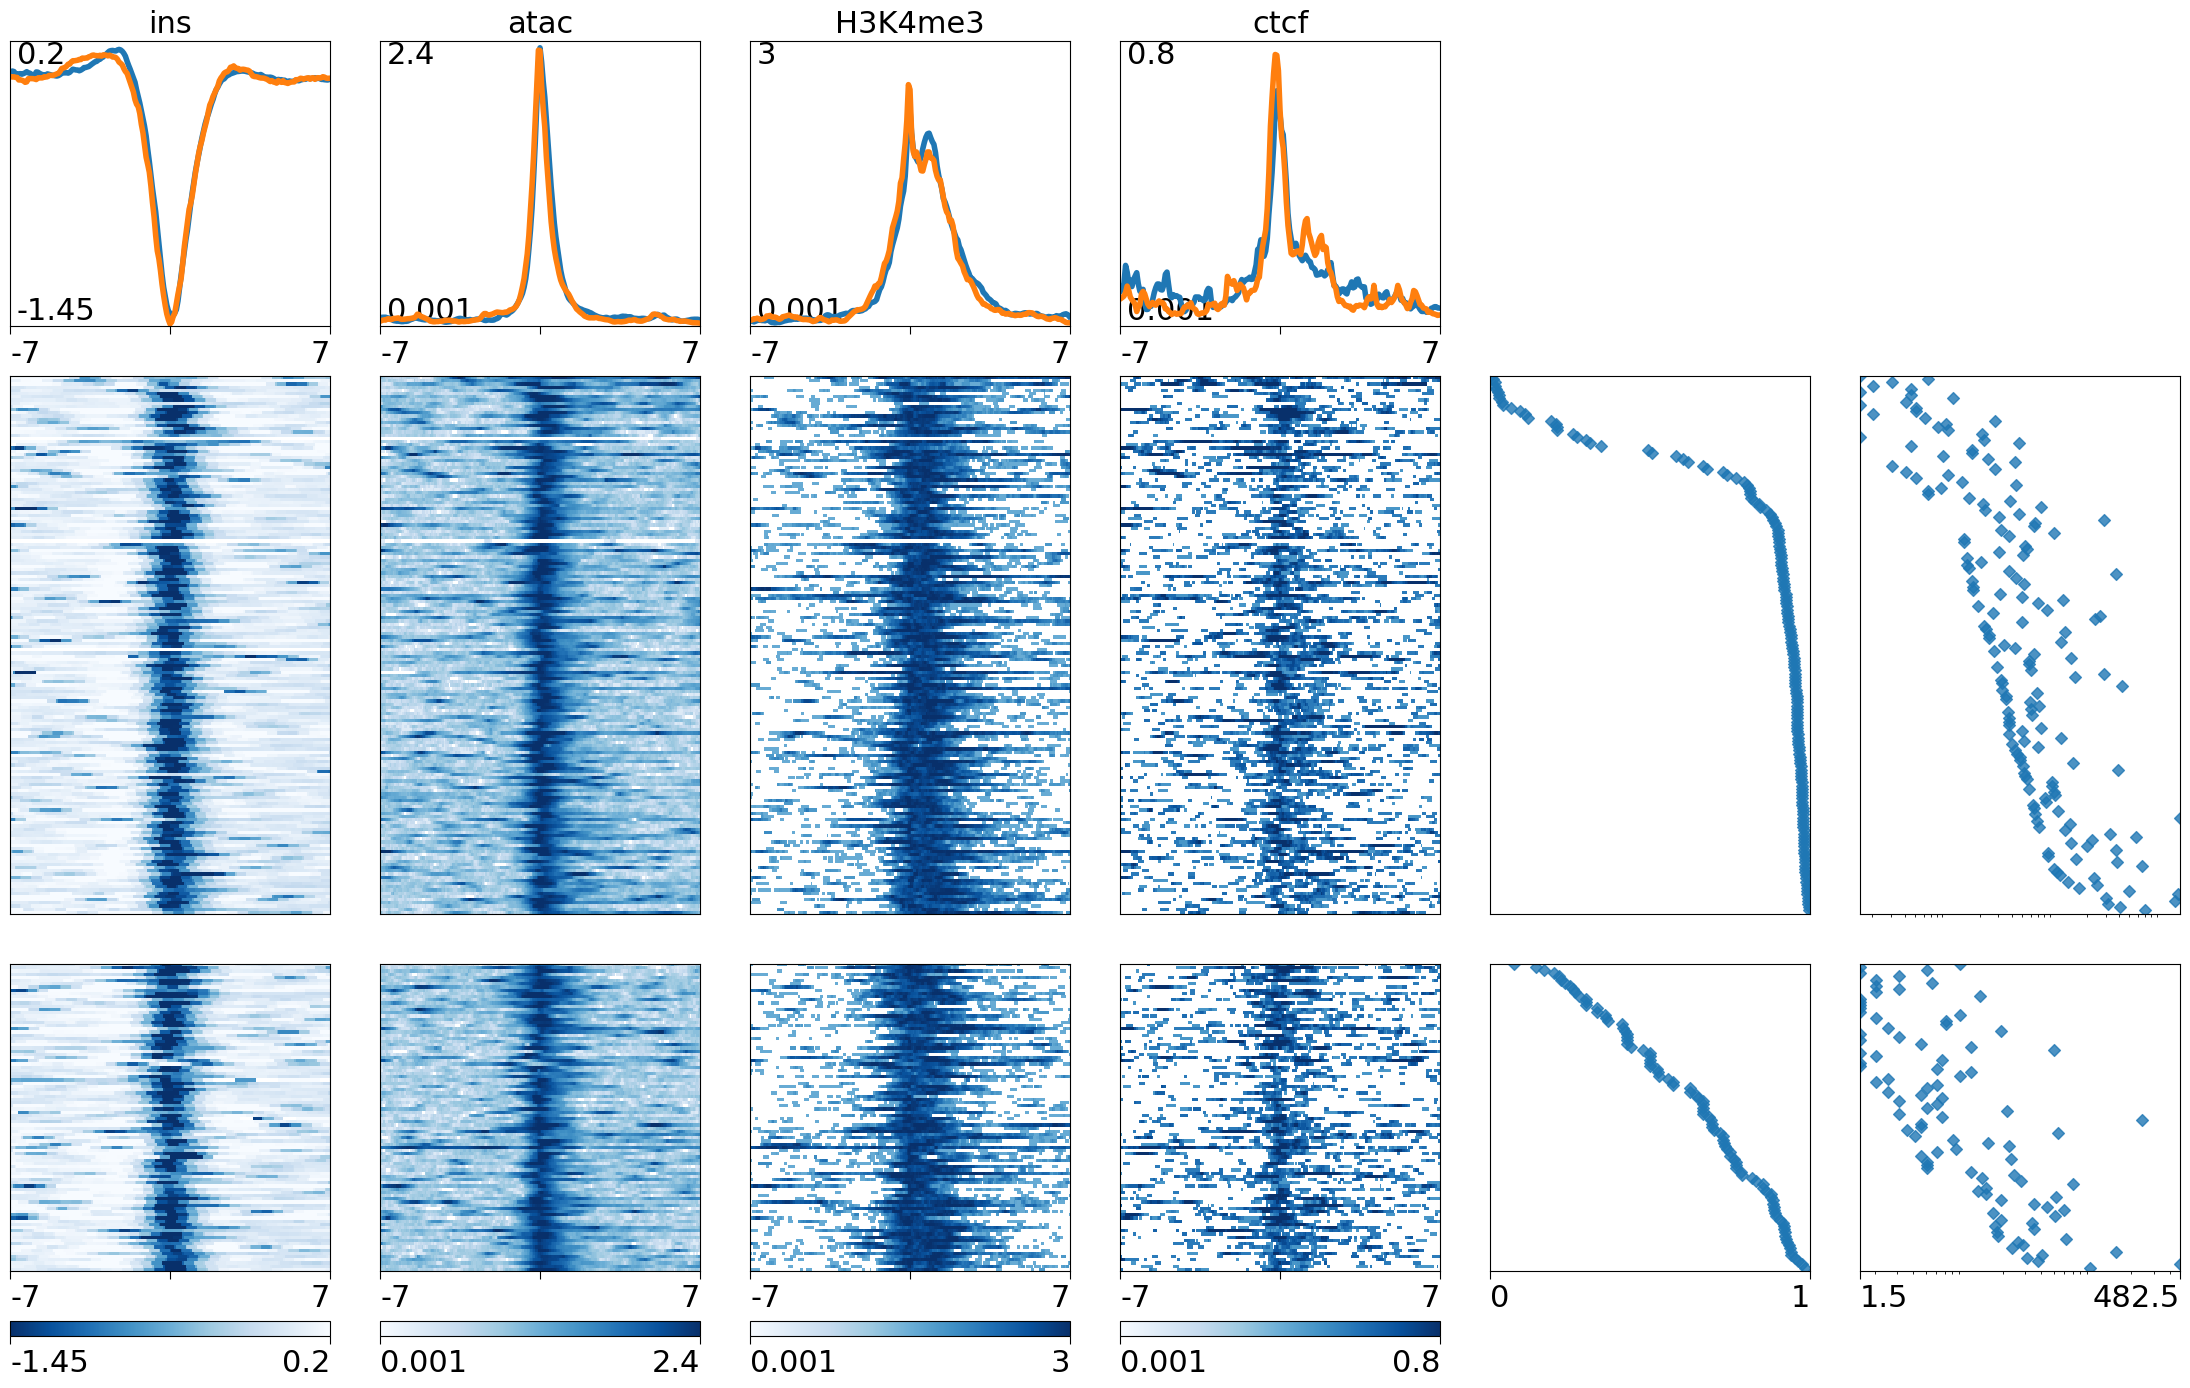

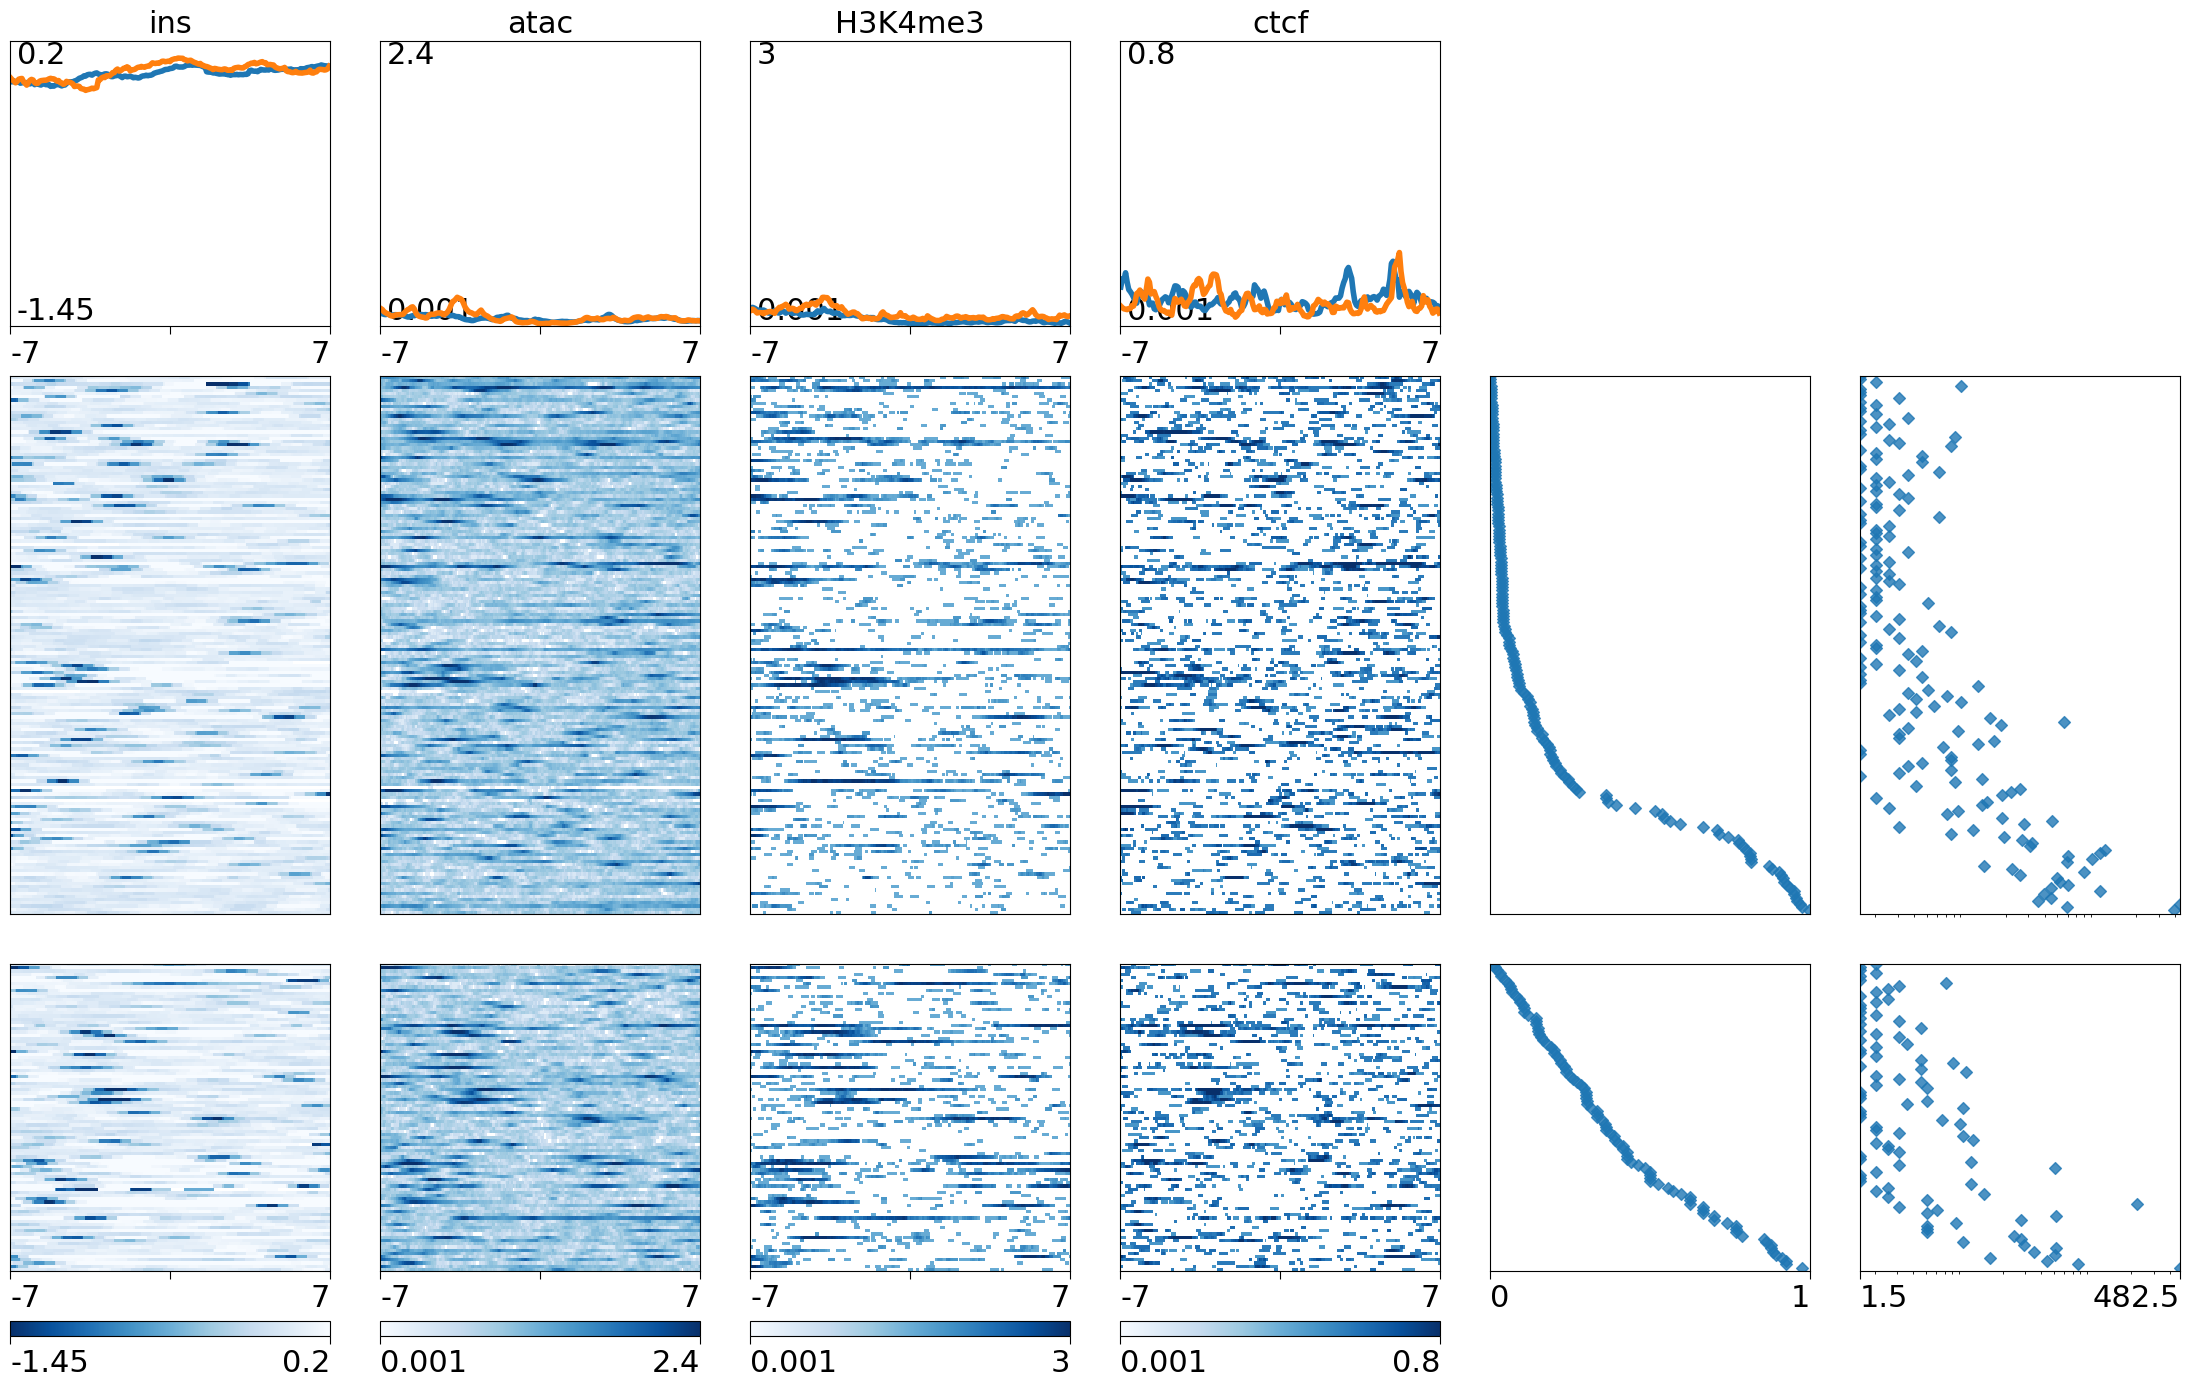

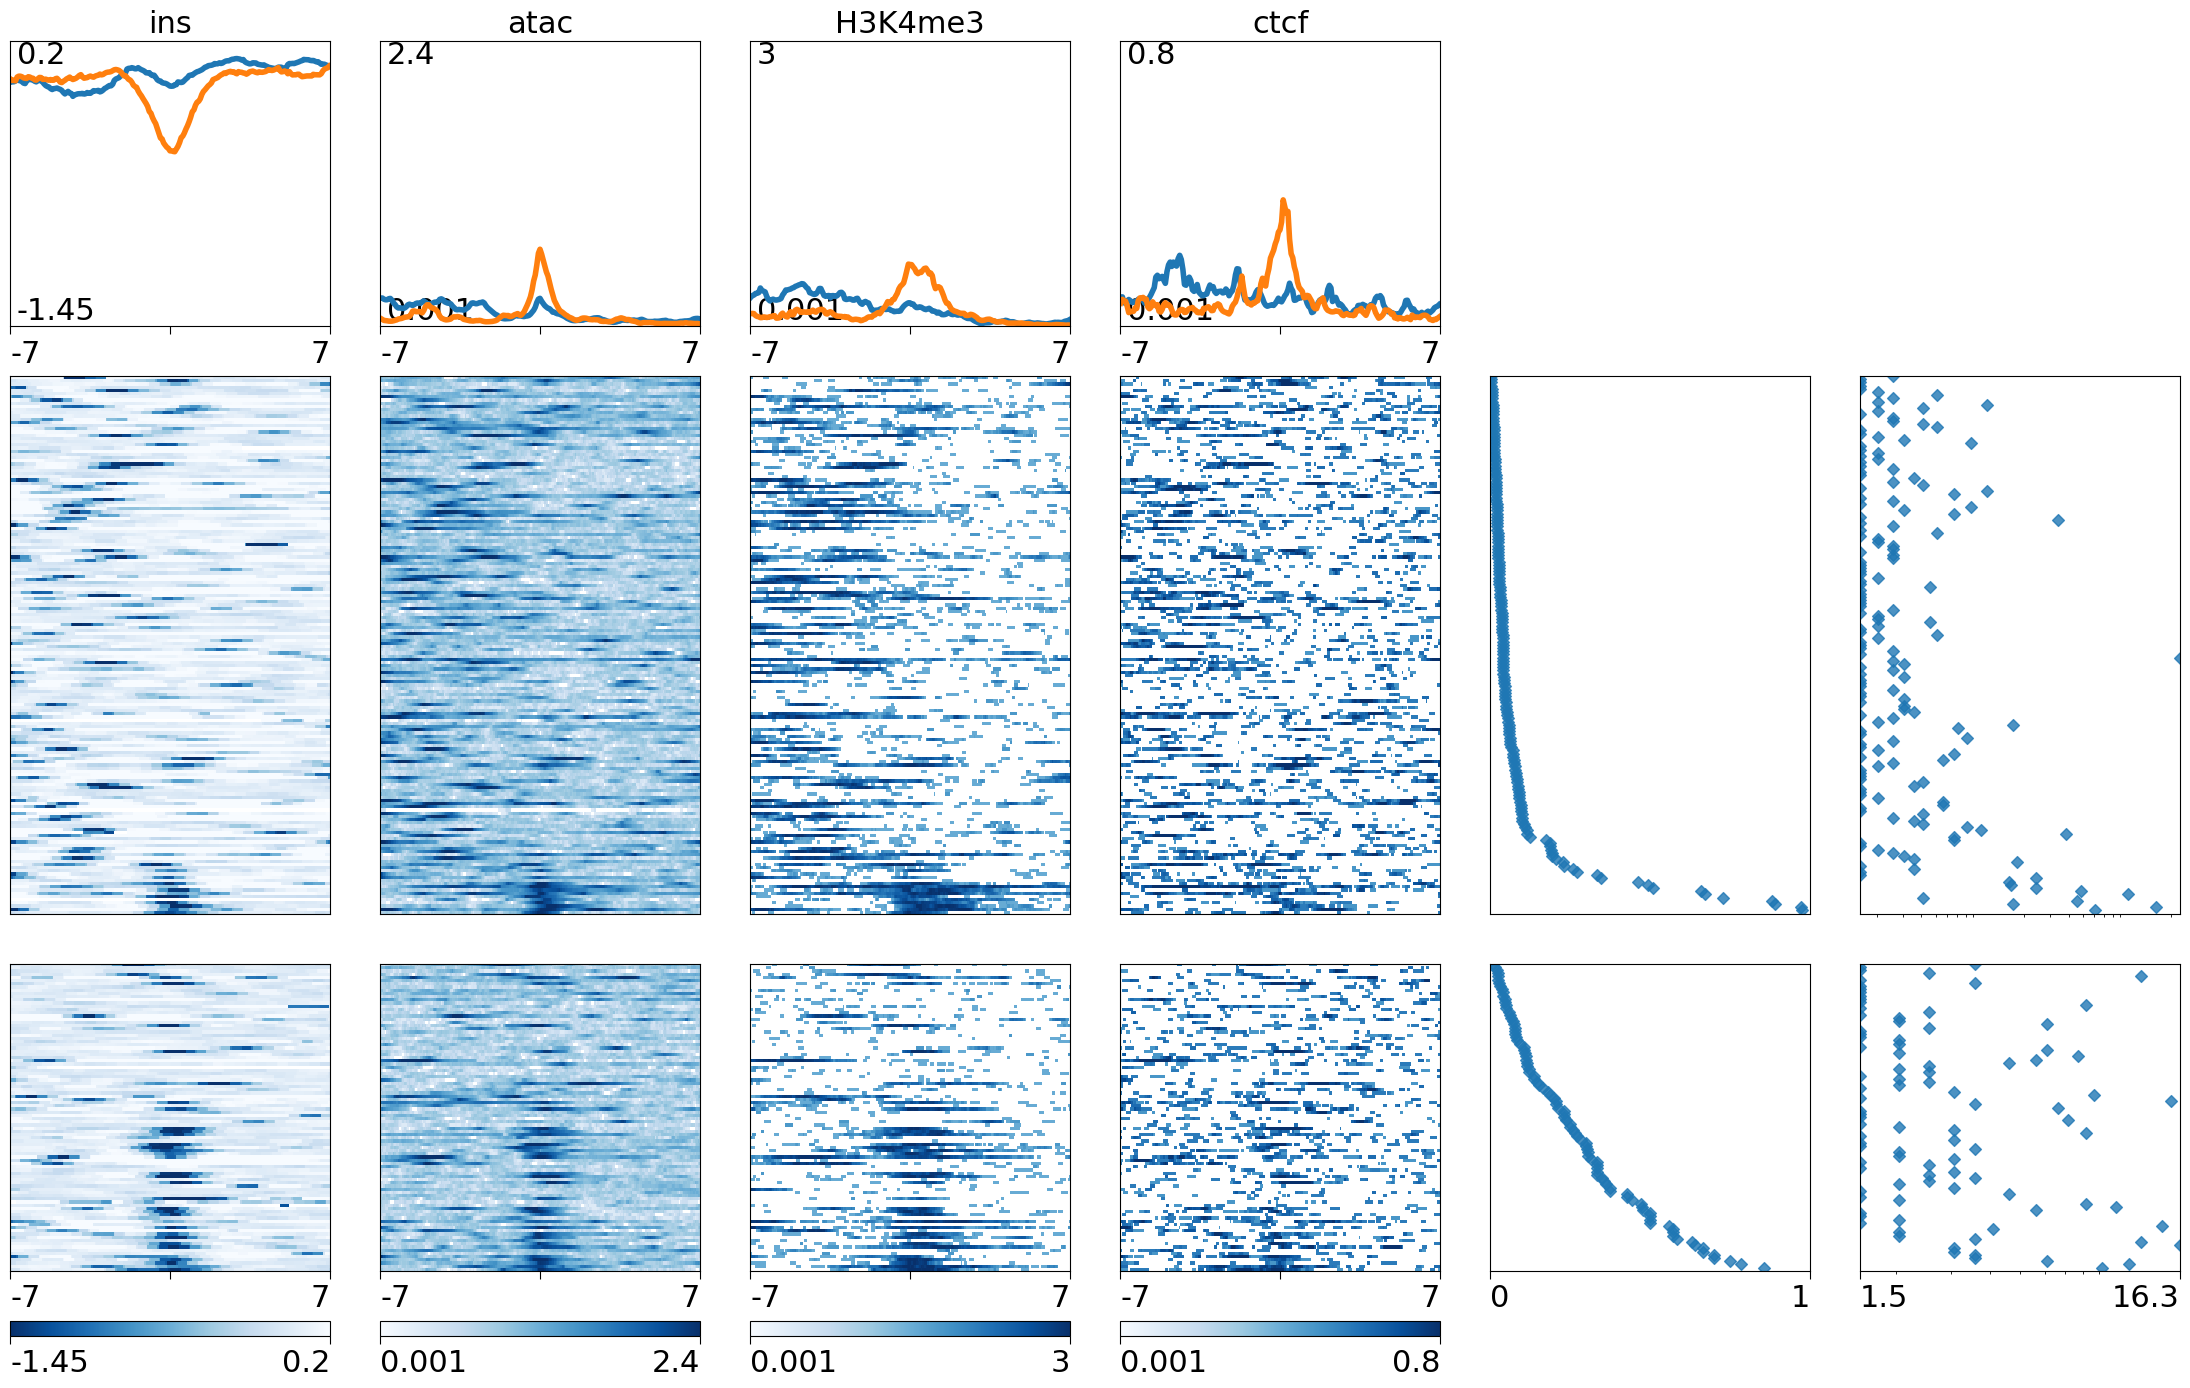

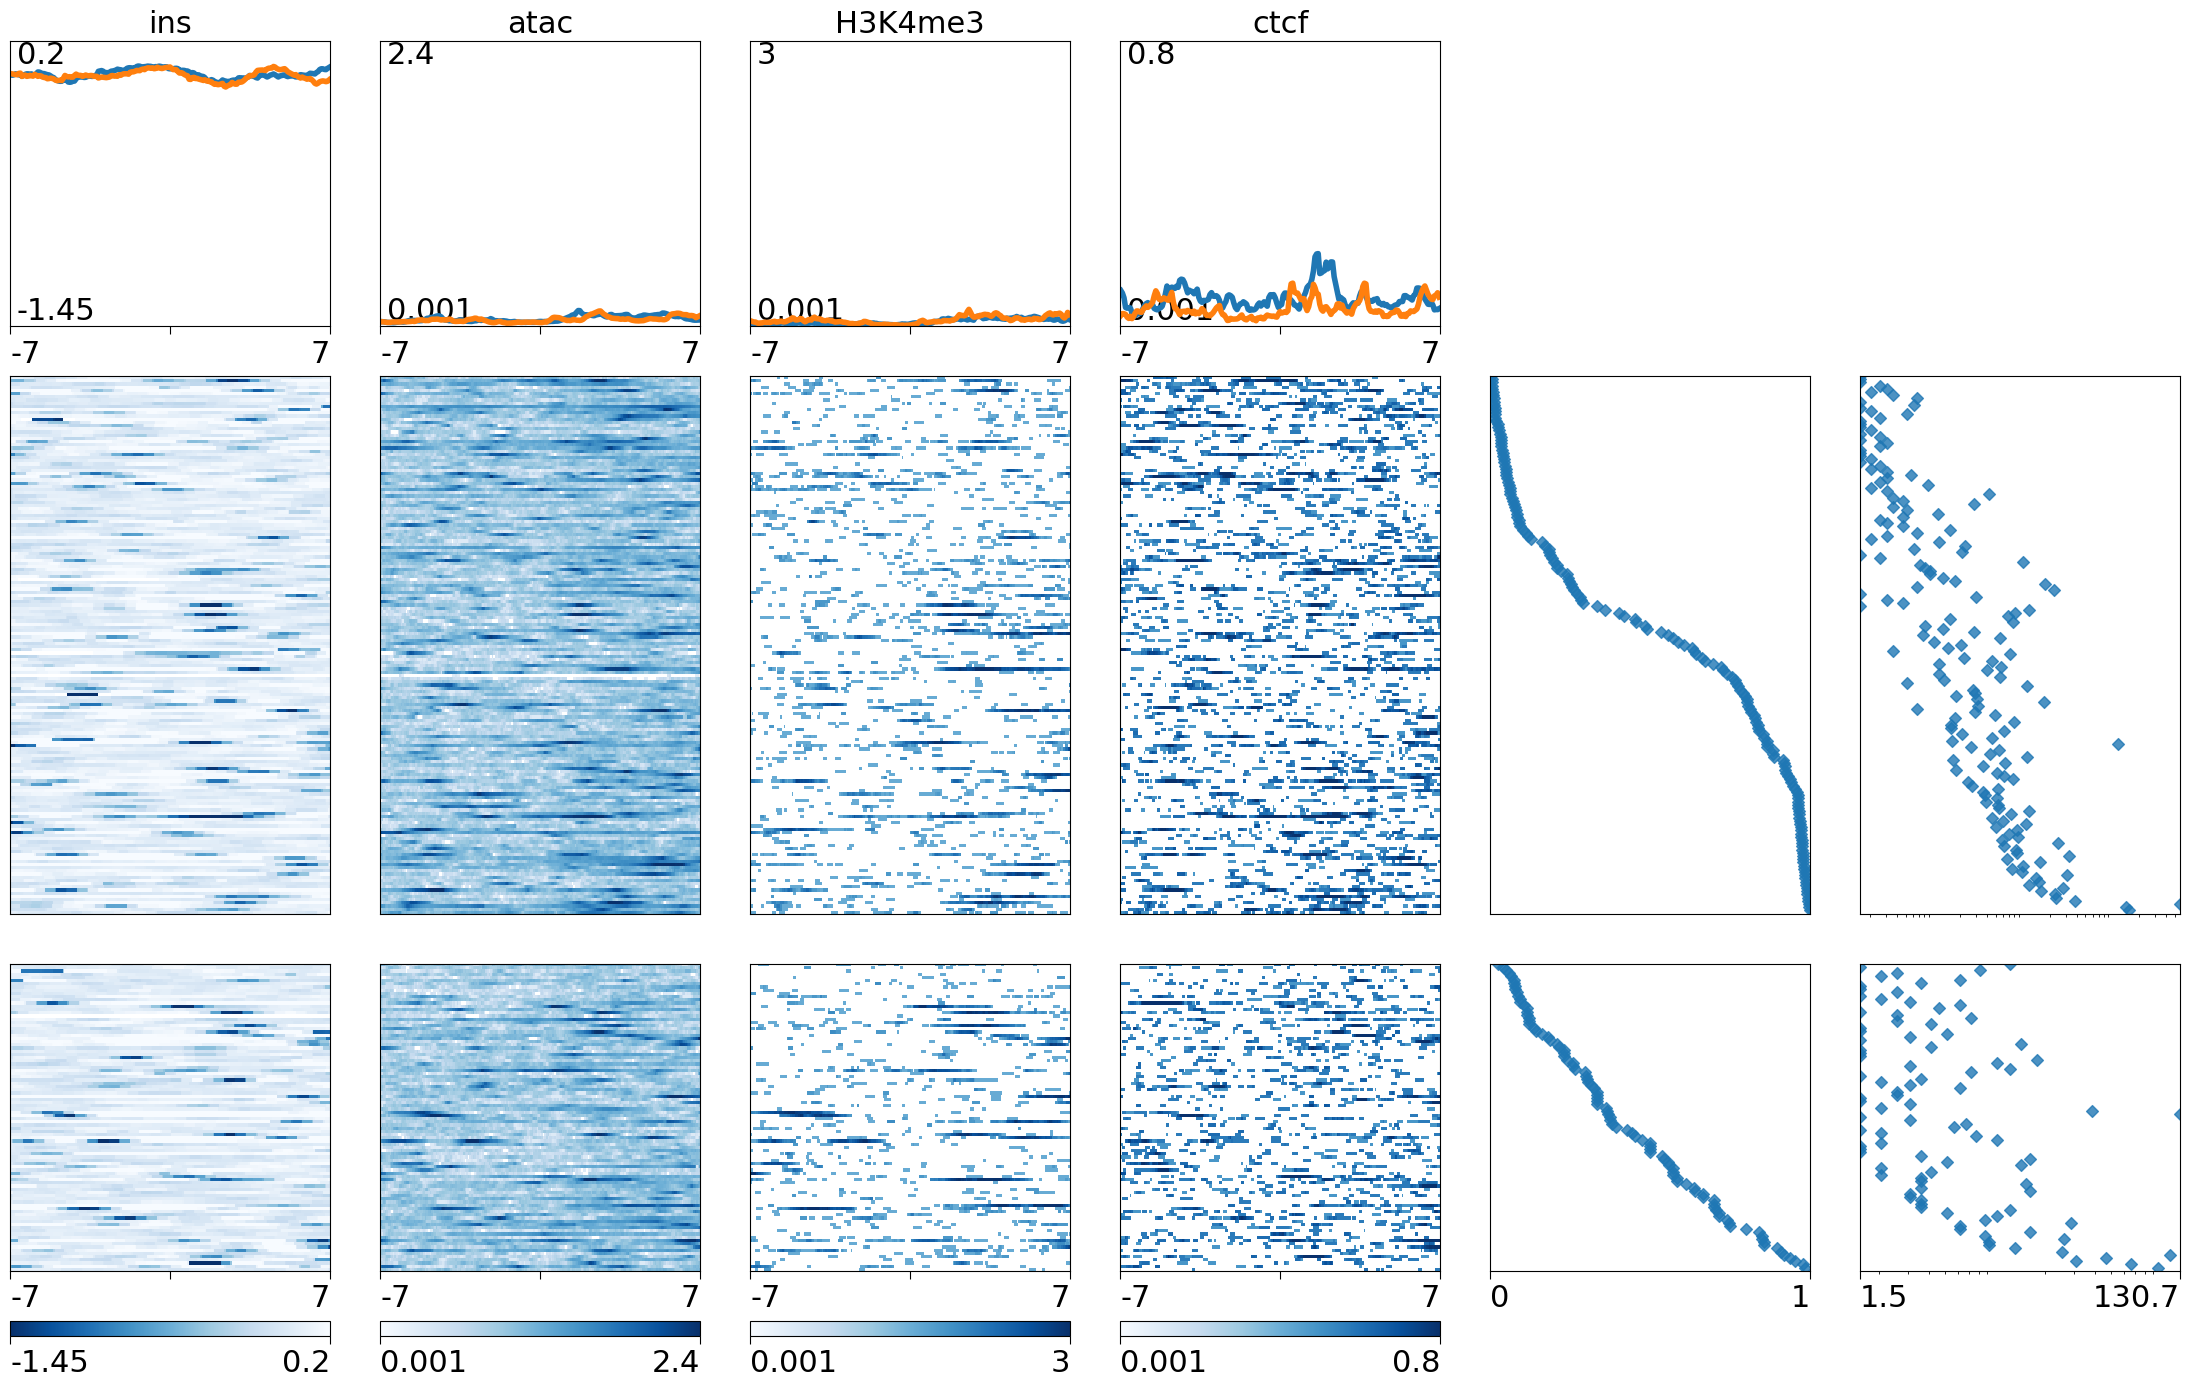

In [266]:
keys_to_display = list(stackups)

# kkk = 'up_tes'
for kkk in ['up_tss', 'up_tes', 'down_tss', 'down_tes']:
    
    scales = {}
    vlims = {}
    cmaps = {}

    if _cell == "esc":
        # # good for insulations ...
        scales["ins"] = "linear"
        vlims["ins"] = (-1.4, 0.2)
        cmaps["ins"] = "Blues_r"
        # # good for chip-s
        scales["atac"] = "log"
        vlims["atac"] = (0.001, 1)
        cmaps["atac"] = "Blues"
        # # good for chip-s
        scales["H3K4me3"] = "log"
        vlims["H3K4me3"] = (0.001, 3)
        cmaps["H3K4me3"] = "Blues"
        # # good for chip-s
        scales["ctcf"] = "log"
        vlims["ctcf"] = (0.001, 0.6)
        cmaps["ctcf"] = "Blues"
    elif _cell == "hff":
        # # good for insulations ...
        scales["ins"] = "linear"
        vlims["ins"] = (-1.45, 0.2)
        cmaps["ins"] = "Blues_r"
        # # good for chip-s
        scales["atac"] = "log"
        vlims["atac"] = (0.001, 2.4)
        cmaps["atac"] = "Blues"
        # # good for chip-s
        scales["H3K4me3"] = "log"
        vlims["H3K4me3"] = (0.001, 3)
        cmaps["H3K4me3"] = "Blues"
        # # good for chip-s
        scales["ctcf"] = "log"
        vlims["ctcf"] = (0.001, 0.8)
        cmaps["ctcf"] = "Blues"
    
    titles = {k: k for k in keys_to_display}
    # cmaps["H3K4me3"] = "Reds"
    binsizes = {k: ((2*_flank) // _nbins) for k in keys_to_display}
    
    # # heatmaps dict, that controls the order, the amount etc etc ...
    # substack_keys = {
    #     t : { k:d[k][ get_order(kkk,t,_cell) ] for k in keys_to_display }
    #     for t,d in stackups.items()
    # }
    
    substack_keys = {}
    # ctrl vs pita ...
    for t in stackups["ins"]:
        substack_keys[t] = {}
    
    for t in substack_keys:
        for k,d in stackups.items():
            substack_keys[t][k] = d[t][kkk][ get_order(kkk,t,_cell) ]
    
    
    # substack_keys = {
    #     t : { bb : dd[kkk][ get_order(kkk,t,_cell) ] for t, dd in d.items() }
    #     for bb, d in stackups.items()
    # }

    _xfsize = 22
    
    axx = plot_stackups_sets(
        2,
        substack_keys,
        scales,
        vlims,
        titles,
        cmaps,
        binsizes,
        fillmissing=False,
        len_per_thousand=32,
        width_per_stack=3.2,
        extra_height=3.,  # height that goes toward the profile and colorbar
        delta_h=.5,  # fixed distance between axes (vertically)
        delta_w=.5,  # fixed distance between axes (horizontal
        fig_fontsize=_xfsize,
        interpolation="none",
    )
    
    ##################################################################
   
    for ii, t in enumerate(stackups["ins"]):
        # for k in keys_to_display:
        _idx = get_order(kkk,t,_cell)
        _df_order = extract_in_order(kkk,t,_cell)
        _,_pos = kkk.split("_")
    
        _psimin = _df_order[f"{_pos}PSI"].min()
        _psimax = _df_order[f"{_pos}PSI"].max()
        
        _tpmin = _df_order[f"{_pos}TPM"].min()
        _tpmax = _df_order[f"{_pos}TPM"].max()
    
    
        axx[0][ii].scatter(
            x = _df_order[f"{_pos}PSI"].loc[_idx],
            y = np.arange(len(_df_order)),
            marker="D",
            alpha=0.8,
        )
        axx[0][ii].set_ylim(len(_df_order), 0)
        axx[0][ii].set_xlim(0,1)
        # axx[0][ii].set_xlim(common_width_max,0)
        axx[1][ii].scatter(
            x = _df_order[f"{_pos}TPM"].loc[_idx],
            y = np.arange(len(_df_order)),
            marker="D",
            alpha=0.8,
        )
        axx[1][ii].set_xlim([_tpmin,_tpmax])
        axx[1][ii].set_ylim(len(_df_order), 0)
        axx[1][ii].set_xscale("log")

        axx[0][ii].set_yticks([])
        axx[0][ii].set_yticklabels([])
        axx[1][ii].set_yticks([])
        axx[1][ii].set_yticklabels([])
    
        if ii == 1:
            axx[0][ii].set_xticks([0,1])
            axx[0][ii].set_xticklabels([0,1],fontsize=_xfsize)
            for _tidx, tick in enumerate(axx[0][ii].xaxis.get_majorticklabels()):
                if _tidx == 0:
                    tick.set_horizontalalignment("left")
                else:
                    tick.set_horizontalalignment("right")
            axx[0][ii].tick_params(axis="x", length=6)        
        else:
            axx[0][ii].set_xticks([])
            axx[0][ii].set_xticklabels([])

        if ii == 1:
            axx[1][ii].set_xticks([_tpmin,_tpmax])
            axx[1][ii].set_xticklabels([f"{_tpmin:.1f}",f"{_tpmax:.1f}"],fontsize=_xfsize)
            for _tidx, tick in enumerate(axx[1][ii].xaxis.get_majorticklabels()):
                if _tidx == 0:
                    tick.set_horizontalalignment("left")
                else:
                    tick.set_horizontalalignment("right")
            axx[1][ii].tick_params(axis="x", length=6)        
        else:
            axx[1][ii].set_xticks([])
            axx[1][ii].set_xticklabels([])

            
    plt.savefig(f"SuppFig_{kkk}_{_cell}.pdf")

### Extract insulation values for Ezequiel

In [267]:
import pprint
pp = pprint.PrettyPrinter(depth=4,width=10)
# pp.pprint(mydict)

In [268]:
_cell

'hff'

In [274]:
keys_to_display = list(stackups)


ppp = {}

for kkk in ['up_tss', 'up_tes', 'down_tss', 'down_tes']:

    if "tss" in kkk:
    
        binsizes = {k: ((2*_flank) // _nbins) for k in keys_to_display}
    
        substack_keys = {}
        # ctrl vs pita ...
        for t in stackups["ins"]:
            substack_keys[t] = {}
        
        for t in substack_keys:
            for k,d in stackups.items():
                    substack_keys[t][k] = d[t][kkk][ get_order(kkk,t,_cell) ]

        dfs = []
        for t in stackups["ins"]:
            df = pd.DataFrame(
                data=substack_keys[t]["ins"],
                columns=[f"bin{_i}" for _i in range(_nbins)]
            )
            df["type"] = t
            _idx = get_order(kkk,t,_cell)
            
            _df_order = extract_in_order(kkk,t,_cell)
            _,_pos = kkk.split("_")
            df["PSI"] = _df_order[f"{_pos}PSI"].loc[_idx].to_numpy()
            df["geneName"] = _df_order["geneName"].loc[_idx].to_numpy()
            dfs.append(df)
        #
        # # display(pd.concat(dfs,ignore_index=True))
        # pd.concat(dfs,ignore_index=True).to_csv(f"{_cell}_{kkk}_insulation.tsv",sep="\t",index=False)
        ppp[kkk] = pd.concat(dfs,ignore_index=True)


In [275]:
! readlink -f *_insulation.tsv

/home/sergpolly/Desktop/pita-proj/esc_down_tss_insulation.tsv
/home/sergpolly/Desktop/pita-proj/esc_up_tss_insulation.tsv
/home/sergpolly/Desktop/pita-proj/hff_down_tss_insulation.tsv
/home/sergpolly/Desktop/pita-proj/hff_up_tss_insulation.tsv


In [276]:
# ! head hff_down_tss_insulation.tsv

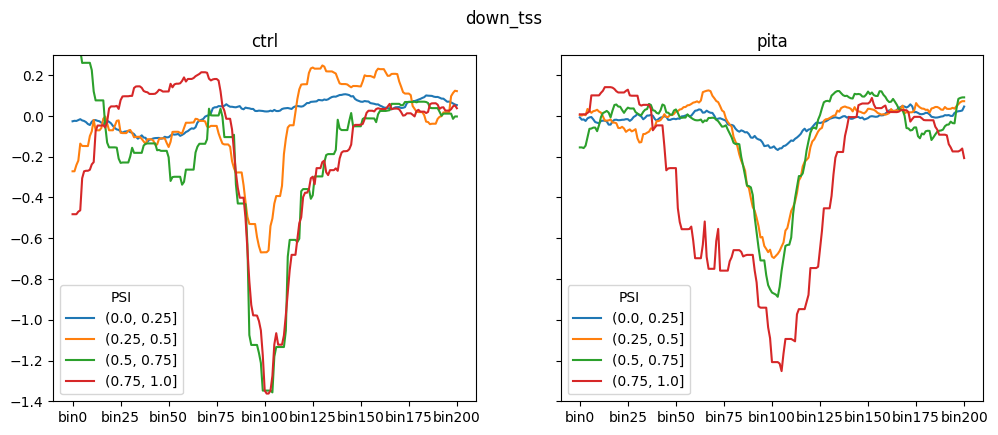

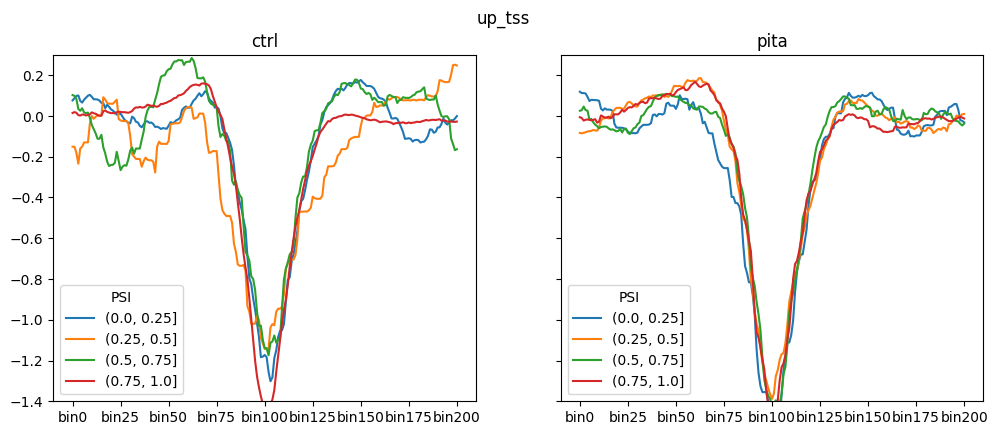

In [281]:
for kkk in ["down_tss","up_tss"]:

    iiii = ppp[kkk][ppp[kkk]["type"]=="pita"].groupby(
        pd.cut(
            ppp[kkk][ppp[kkk]["type"]=="pita"]["PSI"],
            np.linspace(0,1,5),
        )
    )
    cccc = ppp[kkk][ppp[kkk]["type"]=="ctrl"].groupby(
        pd.cut(
            ppp[kkk][ppp[kkk]["type"]=="ctrl"]["PSI"],
            np.linspace(0,1,5),
        )
    )
    
    
    f,axs = plt.subplots(ncols=2,figsize=(12,4.5),sharey=True,sharex=True)
    
    f.suptitle(kkk)
    
    ax = axs[0]
    cccc[[f"bin{_i}" for _i in range(_nbins)]].mean().T.plot(ax = ax)
    ax.set_title("ctrl")
    ax.set_ylim(-1.4,0.3)
    
    ax = axs[1]
    iiii[[f"bin{_i}" for _i in range(_nbins)]].mean().T.plot(ax = ax)
    ax.set_title("pita")
    ax.set_ylim(-1.4,0.3)

    plt.savefig(f"{_cell}_{kkk}_insulation_byPSI.png")

In [283]:
! readlink -f *.png

/home/sergpolly/Desktop/pita-proj/hff_down_tss_insulation_byPSI.png
/home/sergpolly/Desktop/pita-proj/hff_up_tss_insulation_byPSI.png


<Axes: >

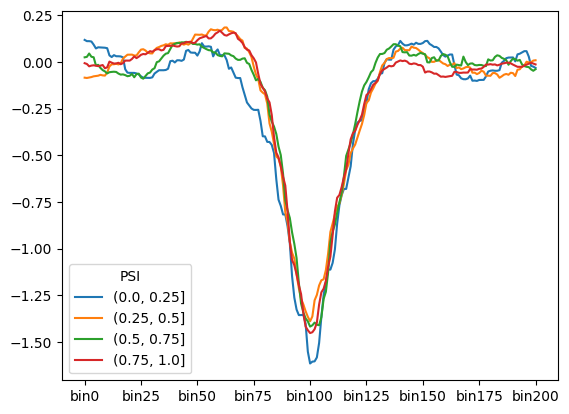

In [265]:
iiii[[f"bin{_i}" for _i in range(_nbins)]].mean().T.plot()

In [34]:

# # # good for insulations ...
# scales = {k: "linear" for k in stackups["ctrl"]}
# vlims = {k: (-1.4, 0.2) for k in stackups["ctrl"]}
# cmaps = {k: "Blues_r" for k in stackups["ctrl"]}
# # # good for chip-s
# # scales = {k: "log" for k in stackups["ctrl"]}
# # vlims = {k: (0.1, 5) for k in stackups["ctrl"]}
# # cmaps = {k: "Blues" for k in stackups["ctrl"]}

# titles = {k: k for k in stackups["ctrl"]}
# # cmaps["H3K4me3"] = "Reds"
# binsizes = {k: ((2*_flank) // _nbins) for k in stackups["ctrl"]}

# plot_stackups_sets(
#     None,
#     stackups,  # heatmaps dict, that controls the order, the amount etc etc ...
#     scales,
#     vlims,
#     titles,
#     cmaps,  
#     binsizes,
#     fillmissing=False,
#     len_per_thousand=32,
#     width_per_stack=3.2,
#     extra_height=3.,  # height that goes toward the profile and colorbar
#     delta_h=.5,  # fixed distance between axes (vertically)
#     delta_w=.5,  # fixed distance between axes (horizontal
#     interpolation="none",
# );

## Make a scatter plot of 2 PSI's colored with the insulation dip  ...

In [46]:
_idx = _ordering["pita"]
_alt = "down"
_type = "pita"
_cell = "esc"
#
_mask_plus = (
    (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
    (_annot_bed["strand"] == "+")
)
# -
_mask_minus = (
    (_annot_bed["sname"] == f"{_alt}_{_type}_{_cell}") &
    (_annot_bed["strand"] == "-")
)

_xxx = pd.concat([ _annot_bed[_mask_plus], _annot_bed[_mask_minus]], ignore_index=True)

# stackups[_cell]

_X = _xxx["tssPSI"].loc[_idx]
_Y = _xxx["tesPSI"].loc[_idx]

# _xxx = pd.concat([ _annot_bed[_mask_plus], _annot_bed[_mask_minus]], ignore_index=True)


In [47]:
# stackups[_type][f"{_alt}_tss"][:,75:125].mean(axis=1)

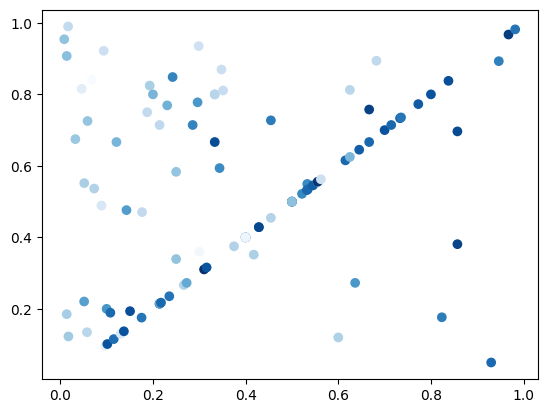

In [49]:
plt.scatter(
    _X,_Y,c = stackups[_type][f"down_tss"][:,75:125].mean(axis=1),
    cmap="Blues_r",
    # vmin=-1.4,vmax = .2
)

<Axes: >

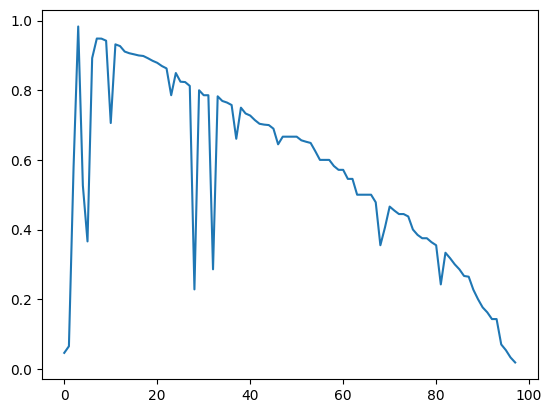

In [225]:
(_xxx.loc[_idx]["tssPSI"]).reset_index(drop=True).plot()

<Axes: >

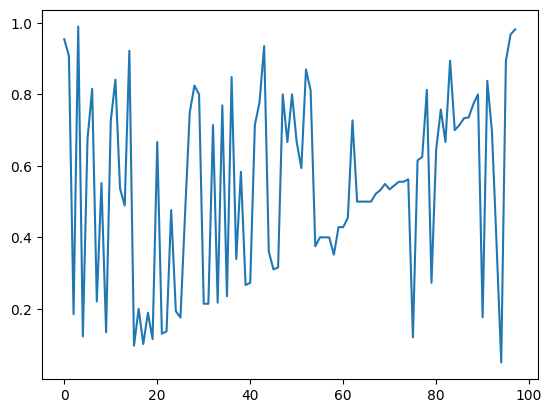

In [222]:
(_xxx.loc[_idx]["tesPSI"]).reset_index(drop=True).plot()

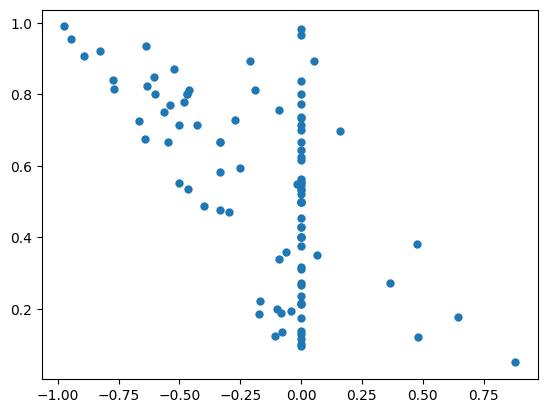

In [216]:
plt.scatter(_xxx.loc[_idx]["tssPSI"] - _xxx.loc[_idx]["tesPSI"], _xxx.loc[_idx]["tesPSI"],marker="o",lw=0)

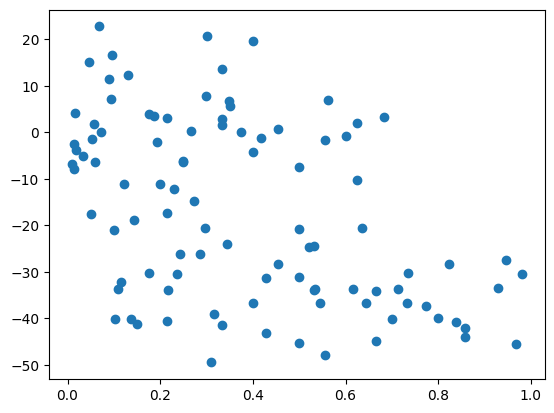

In [35]:
plt.scatter(_X, stackups[_type][f"down_tss"][:,75:125].sum(axis=1))

<Axes: >

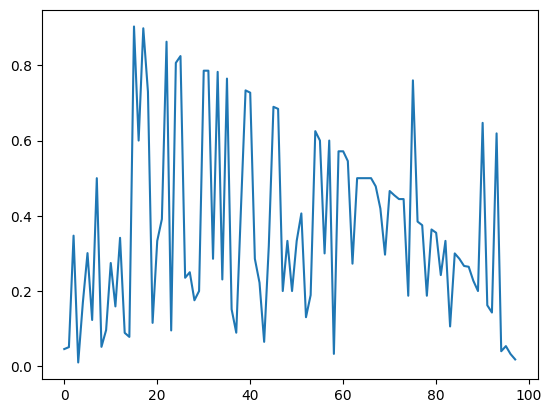

In [228]:
_xxx.loc[_idx]["tesPSI"].reset_index(drop=True).plot()

# Some attempts at the META-gene stackups ...

In [284]:
_chrom = _annot_bed["chrom"]
_width = _annot_bed.eval("end - start")
_start = _annot_bed["start"] - _width
_end = _annot_bed["end"] + _width


_stack = bbi.stackup(
    # "bigwigs/hESC_Atacseq.mRp.clN.bigWig", 
    "xxx.bw",
    _chrom,
    _start,
    _end,
    bins=300,
)

/tmp/ipykernel_767768/676697252.py:9: RuntimeWarning: Mean of empty slice
  _sss = (_stack[_sub_index].T - np.nanmean(_stack[_sub_index,:40],axis=1) - np.nanmean(_stack[_sub_index,-40:],axis=1)).T
/tmp/ipykernel_767768/676697252.py:11: RuntimeWarning: Mean of empty slice
  _idx = np.argsort(np.nanmean(_sss[:,190:210],axis=1))


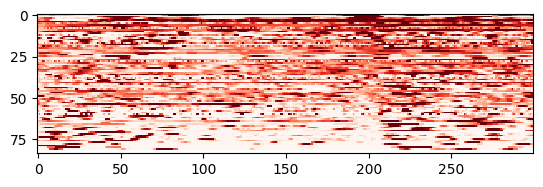

In [299]:
_mask = (_annot_bed["sname"].str.contains("esc") & \
    _annot_bed["sname"].str.contains("down") & \
    _annot_bed["sname"].str.contains("ctrl") & \
     (_annot_bed["strand"] == "-") )


_sub_index = _annot_bed[_mask].index

_sss = (_stack[_sub_index].T - np.nanmean(_stack[_sub_index,:40],axis=1) - np.nanmean(_stack[_sub_index,-40:],axis=1)).T
# _sss = _stack[_sub_index]
_idx = np.argsort(np.nanmean(_sss[:,190:210],axis=1))

plt.imshow(
    # _stack[_sub_index],
    _sss[_idx],
    # norm=mpl.colors.LogNorm(),
    norm=mpl.colors.Normalize(vmin=-0.3,vmax=.2),
    cmap="Reds_r",
    interpolation="none"
)


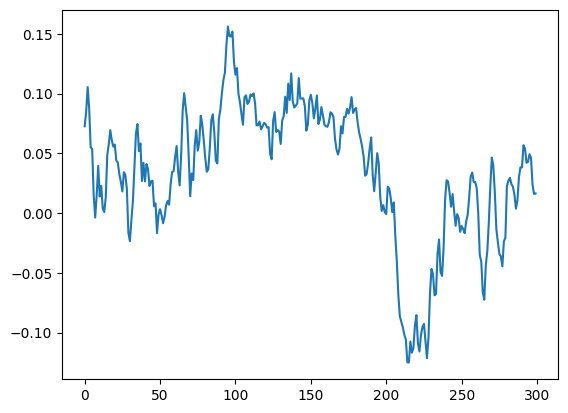

In [300]:
 
plt.plot(np.nanmean(_sss,axis=0))

/tmp/ipykernel_767768/229697764.py:8: RuntimeWarning: Mean of empty slice
  _sss = (_stack[_sub_index].T - np.nanmean(_stack[_sub_index,:40],axis=1) - np.nanmean(_stack[_sub_index,-40:],axis=1)).T
/tmp/ipykernel_767768/229697764.py:10: RuntimeWarning: Mean of empty slice
  _idx = np.argsort(np.nanmean(_sss[:,90:110],axis=1))


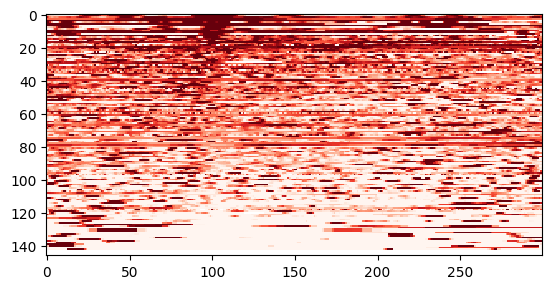

In [287]:
_mask = (_annot_bed["sname"].str.contains("esc") & \
    _annot_bed["sname"].str.contains("down") & \
    _annot_bed["sname"].str.contains("ctrl") & \
     (_annot_bed["strand"] == "+") )

_sub_index = _annot_bed[_mask].index

_sss = (_stack[_sub_index].T - np.nanmean(_stack[_sub_index,:40],axis=1) - np.nanmean(_stack[_sub_index,-40:],axis=1)).T

_idx = np.argsort(np.nanmean(_sss[:,90:110],axis=1))

plt.imshow(
    # _stack[_sub_index],
    _sss[_idx],
    # norm=mpl.colors.LogNorm(),
    norm=mpl.colors.Normalize(vmin=-0.3,vmax=.2),
    cmap="Reds_r",
    interpolation="none"
)


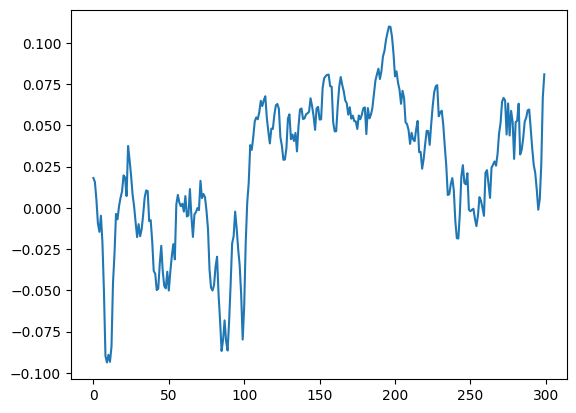

In [288]:
plt.plot(np.nanmean(_sss,axis=0))

# old stuff ...

In [431]:
# test middle coords
for _strand in ["+", "-"]:
    for _df in [pita_esc, pita_hff, ctrl_esc, ctrl_hff]:
        print(f"current strand is {_strand}")
        # df = ctrl_hff
        # strand="-"
        _reverse = True if _strand=="-" else False

        _df = _df.query(f"strand=='{_strand}'").reset_index(drop=True)
        print(f"number| of items {len(_df)}")
        # _res = _df["exonStarts"].str.split(",").apply(lambda x: x == sorted(x, reverse=_reverse)).value_counts()
        _res = _df["exonStarts"].str.split(",").apply(lambda x: ",".join([str(int(_)-int(x[0])) for _ in x]) )
        
        display(_res)

current strand is +
number| of items 63


0       0,94732,38168,103190
1        0,39534,29269,64693
2        0,38957,16304,59311
3        0,32363,40915,84326
4         0,13059,4366,13933
               ...          
58    0,172025,162976,187679
59     0,85353,134427,158796
60     0,322189,42130,342699
61        0,13674,6241,19170
62     0,135635,20482,138446
Name: exonStarts, Length: 63, dtype: object

current strand is +
number| of items 63


0     0,289762,285523,338143
1      0,148522,56818,149486
2        0,48417,48365,76616
3     0,126931,117666,153882
4        0,46831,27426,54849
               ...          
58    0,100893,154623,171292
59        0,12193,3551,32901
60     0,26377,195555,282642
61        0,10993,6833,17379
62        0,15189,6241,19170
Name: exonStarts, Length: 63, dtype: object

current strand is +
number| of items 127


0      0,60464,60548,77058
1       0,8816,16040,29584
2      0,36080,50015,70064
3      0,19741,17037,46113
4      0,22170,10683,31575
              ...         
122    0,29595,16353,34382
123    0,10754,11506,31192
124     0,60661,9748,66481
125    0,30724,22616,32464
126      0,9765,8132,20634
Name: exonStarts, Length: 127, dtype: object

current strand is +
number| of items 94


0       0,17912,25990,63549
1     0,116070,76582,121678
2       0,10315,27797,35795
3        0,21784,8645,96910
4       0,8365,72623,113459
              ...          
89       0,10989,4663,12299
90    0,25484,247244,557994
91      0,21450,20256,38028
92      0,33982,22115,38370
93      0,29095,39630,63418
Name: exonStarts, Length: 94, dtype: object

current strand is -
number| of items 55


0      0,-193579,-107938,-223145
1          0,-10406,-1308,-12465
2         0,-26076,-13612,-76314
3         0,-57547,-36055,-58859
4          0,-43461,-4567,-97101
5         0,-10816,-13299,-22637
6       0,-132065,-95905,-135216
7         0,-26619,-19270,-33706
8         0,-19635,-17311,-24967
9           0,-9896,-1087,-14321
10          0,-33707,-597,-47686
11        0,-27309,-25484,-71223
12           0,-27151,-60,-61742
13          0,-9943,-4551,-15746
14        0,-36219,-20882,-74884
15        0,-29215,-1319,-113629
16         0,-12546,-7474,-59346
17         0,-22494,-6099,-38729
18        0,-38305,-14780,-59390
19         0,-93490,-4264,-94838
20         0,-36384,-7174,-97912
21        0,-17851,-11435,-27968
22     0,-702126,-95453,-1284692
23     0,-167609,-146508,-182495
24      0,-233962,-65901,-330328
25          0,-9383,-7652,-23772
26        0,-62774,-17306,-90415
27      0,-125951,-31473,-234557
28        0,-23864,-1189,-123993
29        0,-68813,-6032,-123449
30      0,

current strand is -
number| of items 67


0      0,-145583,-40720,-154236
1       0,-82643,-61293,-106099
2        0,-24271,-12053,-50986
3     0,-157528,-102769,-160102
4         0,-25940,-9914,-28155
                ...            
62    0,-265262,-232847,-269858
63     0,-113241,-82750,-256702
64       0,-13642,-12796,-41364
65       0,-31335,-15744,-31782
66       0,-37254,-30707,-40063
Name: exonStarts, Length: 67, dtype: object

current strand is -
number| of items 79


0         0,-10644,-433,-67641
1       0,-10252,-13747,-42479
2       0,-52056,-35810,-52357
3       0,-28786,-15949,-42637
4        0,-23222,-1646,-24398
                ...           
74       0,-9721,-14668,-24907
75      0,-11301,-12460,-64174
76    0,-84304,-142949,-158989
77    0,-16261,-148279,-178459
78      0,-17245,-11869,-21050
Name: exonStarts, Length: 79, dtype: object

current strand is -
number| of items 57


0        0,-21265,-21230,-37652
1      0,-65775,-111304,-146712
2       0,-26532,-72635,-105116
3        0,-7639,-62976,-138679
4        0,-52056,-35810,-52357
5        0,-20738,-27970,-38729
6         0,-8143,-50477,-58839
7        0,-58688,-35691,-80167
8        0,-15046,-16272,-24398
9        0,-12931,-12840,-81827
10       0,-36005,-32406,-51807
11       0,-25728,-20896,-33149
12       0,-11561,-19944,-42559
13      0,-94238,-73339,-106428
14       0,-51068,-67406,-79110
15      0,-18672,-49400,-105906
16       0,-24490,-28459,-46530
17     0,-109057,-25400,-140378
18      0,-120181,-5107,-152521
19     0,-126902,-21396,-139413
20       0,-39043,-12860,-56723
21     0,-209315,-12369,-280138
22       0,-27223,-10802,-49660
23       0,-24467,-51194,-99717
24       0,-67371,-70117,-84864
25        0,-13088,-2608,-51365
26        0,-47784,-3703,-66075
27       0,-22438,-28370,-54976
28       0,-31564,-10346,-38367
29     0,-90138,-171811,-236390
30       0,-12616,-28001,-47407
31      

In [429]:
# test middle coords
for _strand in ["+", "-"]:
    for _df in [pita_esc, pita_hff, ctrl_esc, ctrl_hff]:
        print(f"current strand is {_strand}")
        # df = ctrl_hff
        # strand="-"
        _reverse = True if _strand=="-" else False

        _df = _df.query(f"strand=='{_strand}'").reset_index(drop=True)
        print(f"number| of items {len(_df)}")
        _res = _df["exonStarts"].str.split(",").apply(lambda x: x == sorted(x, reverse=_reverse)).value_counts()
        
        display(_res)


current strand is +
number| of items 63


False    54
True      9
Name: exonStarts, dtype: int64

current strand is +
number| of items 63


False    54
True      9
Name: exonStarts, dtype: int64

current strand is +
number| of items 127


True     66
False    61
Name: exonStarts, dtype: int64

current strand is +
number| of items 94


True     49
False    45
Name: exonStarts, dtype: int64

current strand is -
number| of items 55


False    53
True      2
Name: exonStarts, dtype: int64

current strand is -
number| of items 67


False    59
True      8
Name: exonStarts, dtype: int64

current strand is -
number| of items 79


False    48
True     31
Name: exonStarts, dtype: int64

current strand is -
number| of items 57


True     30
False    27
Name: exonStarts, dtype: int64

In [426]:
def get_left_right_gene(df, strand="+"):
    """
    given exonStarts yield 2 dataframes corresponding to alternative transcription variants ...
    """
    _df = df.query(f"strand=='{strand}'").reset_index(drop=True)
    
    df_left = _df.copy()
    df_right = _df.copy()

    _0 = _df["exonStarts"].str.split(",").str[0].astype(int).to_numpy()
    _1 = _df["exonStarts"].str.split(",").str[1].astype(int).to_numpy()
    _2 = _df["exonStarts"].str.split(",").str[2].astype(int).to_numpy()
    _3 = _df["exonStarts"].str.split(",").str[3].astype(int).to_numpy()
    
    if strand == "+":
        # following is true for "+" strand :
        # left
        df_left["start"] = _0
        df_left["end"] = _1
        # right
        df_right["start"] = _2
        df_right["end"] = _3
    else:
        # following is true for "-" strand :
        # left - kinf of upstream - i.e. main one ...
        df_left["start"] = _0
        df_left["end"] = _1
        # right
        df_right["start"] = _2
        df_right["end"] = _3
    
    return df_left, df_right



In [371]:
# Create of the stackup, the flanks are +- 50 Kb, number of bins is 100 : 
_flank = 2500 # Length of flank to one side from the boundary, in basepairs
_nbins = 200   # Number of bins to split the region
# # _df = yyy.query("end1-start1<50000")
# _df = yyy.loc[yyy.eval("end1-start1").sort_values().index]
# _df = yyy

def get_tss_tts_stacks(bigwig_path, left_df, right_df, flank=5000, nbins=200):
    """
    extract stackups ...
    """

    stackups = {}

    # left transcript
    _df = left_df
    stackups["left_TSS"] = bbi.stackup(bigwig_path, 
                          _df.chrom,
                          _df.eval(f"(start) - {flank}"),
                          _df.eval(f"(start) + {flank}"),
                          bins=nbins
                         )
    stackups["left_TTS"] = bbi.stackup(bigwig_path, 
                          _df.chrom,
                          _df.eval(f"(end) - {flank}"),
                          _df.eval(f"(end) + {flank}"),
                          bins=nbins
                         )
    # right transcript
    _df = right_df
    stackups["right_TSS"] = bbi.stackup(bigwig_path, 
                          _df.chrom,
                          _df.eval(f"(start) - {flank}"),
                          _df.eval(f"(start) + {flank}"),
                          bins=nbins
                         )
    stackups["right_TTS"]  = bbi.stackup(bigwig_path, 
                          _df.chrom,
                          _df.eval(f"(end) - {flank}"),
                          _df.eval(f"(end) + {flank}"),
                          bins=nbins
                         )
    
    return stackups




def show_stacks(stackups, order_idx=None, flank=5000, nbins=200):
    """
    show 4 stackups in the dict ...
    """
    
    if order_idx is None:
        # first key
        _k = stackups.keys()[0]
        # get stack depth
        _stack_depth = stackups[_k].shape[0]
        # order based on depth ...
        order_idx = np.arange(_stack_depth)
    
    len_per_unit_depth = 0.033
    width_per_unit_stack = 3.33

    fig, axs = plt.subplots(
        ncols=len(stackups),
        figsize=[width_per_unit_stack*len(stackups), len_per_unit_depth*len(order_idx)],
        sharey=True,
        sharex=True
    )
    for ax, (name, _stack) in zip(axs, stackups.items()):
        ax.imshow(
            _stack[order_idx],
            norm=mpl.colors.LogNorm(),#(vmin=0.005,vmax=1),
            interpolation="none",
            aspect=2,
            cmap="Blues"
        )
        ax.set_title(name)
        ax.set_xticks([0,nbins/2, nbins])
        ax.set_xticklabels([f"-{flank//1000}kb", "", f"{flank//1000}kb"])

    fig.suptitle(bw_fname)


In [372]:
! ls bigwigs

ENCFF580QUY.bigWig		 hESC_H3K4me3_R1.mLb.clN.bigWig
ENCFF975VIV.bigWig		 hESC_H3K4me3_R2.mLb.clN.bigWig
H1-YY1-1.bigWig			 hESC_H3K4me3_R3.mLb.clN.bigWig
H1-YY1-2.bigWig			 hESC_H3K4me3_R4.mLb.clN.bigWig
H1-YY1-3.bigWig			 hESC_H3K4me3_R5.mLb.clN.bigWig
H1-YY1-4.bigWig			 HFFc6_Atacseq.mRp.clN.bigWig
H1-YY1-5.bigWig			 HFFc6_CTCF_CT.mRp.clN.bigWig
H1-YY1-6.bigWig			 HFFC6_CTCF.mRp.clN.bigWig
hESC_Atacseq.mRp.clN.bigWig	 HFFC6_CTCF_R1.mLb.clN.bigWig
hESC_CTCF.mRp.clN.bigWig	 HFFC6_CTCF_R2.mLb.clN.bigWig
hESC_CTCF_R1.mLb.clN.bigWig	 HFFC6_CTCF_R3.mLb.clN.bigWig
hESC_CTCF_R2.mLb.clN.bigWig	 HFFC6_CTCF_R4.mLb.clN.bigWig
hESC_CTCF_R3.mLb.clN.bigWig	 HFFc6_H3K27ac_R1.mLb.clN.bigWig
hESC_CTCF_R4.mLb.clN.bigWig	 HFFc6_H3K27ac_R2.mLb.clN.bigWig
hESC_CTCF_R5.mLb.clN.bigWig	 HFFc6_H3K27ac_R3.mLb.clN.bigWig
hESC_CTCF_R6.mLb.clN.bigWig	 HFFc6_H3K27ac_R4.mLb.clN.bigWig
hESC_H3K27ac_R1.mLb.clN.bigWig	 HFFc6_H3K27me3_R1.mLb.clN.bigWig
hESC_H3K27ac_R2.mLb.clN.bigWig	 HFFc6_H3K27me3_R2.mLb.clN.bigWig
hE

In [57]:
! head esc_down_tss_insulation.tsv

bin0	bin1	bin2	bin3	bin4	bin5	bin6	bin7	bin8	bin9	bin10	bin11	bin12	bin13	bin14	bin15	bin16	bin17	bin18	bin19	bin20	bin21	bin22	bin23	bin24	bin25	bin26	bin27	bin28	bin29	bin30	bin31	bin32	bin33	bin34	bin35	bin36	bin37	bin38	bin39	bin40	bin41	bin42	bin43	bin44	bin45	bin46	bin47	bin48	bin49	bin50	bin51	bin52	bin53	bin54	bin55	bin56	bin57	bin58	bin59	bin60	bin61	bin62	bin63	bin64	bin65	bin66	bin67	bin68	bin69	bin70	bin71	bin72	bin73	bin74	bin75	bin76	bin77	bin78	bin79	bin80	bin81	bin82	bin83	bin84	bin85	bin86	bin87	bin88	bin89	bin90	bin91	bin92	bin93	bin94	bin95	bin96	bin97	bin98	bin99	bin100	bin101	bin102	bin103	bin104	bin105	bin106	bin107	bin108	bin109	bin110	bin111	bin112	bin113	bin114	bin115	bin116	bin117	bin118	bin119	bin120	bin121	bin122	bin123	bin124	bin125	bin126	bin127	bin128	bin129	bin130	bin131	bin132	bin133	bin134	bin135	bin136	bin137	bin138	bin139	bin140	bin141	bin142	bin143	bin144	bin145	bin146	bin147	bin148	bin149	bin150	bin151	bin152	bin153	bin154	bin155	bin156	bin157	bin1

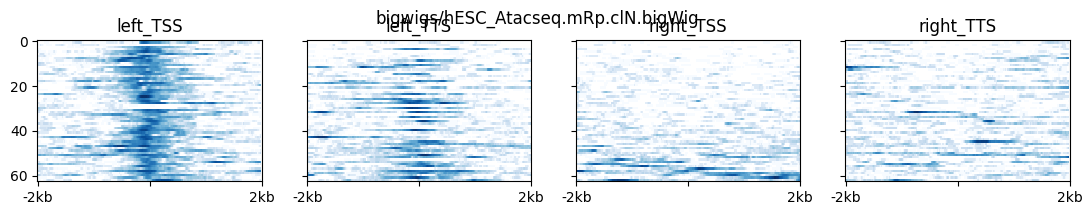

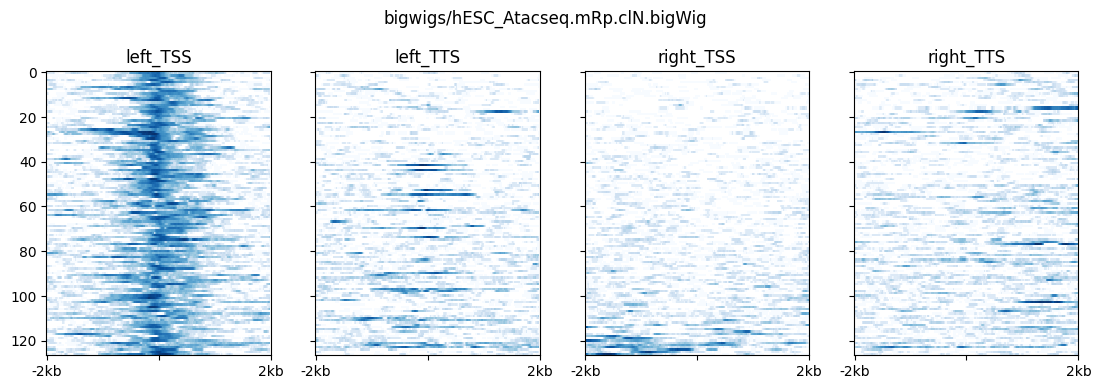

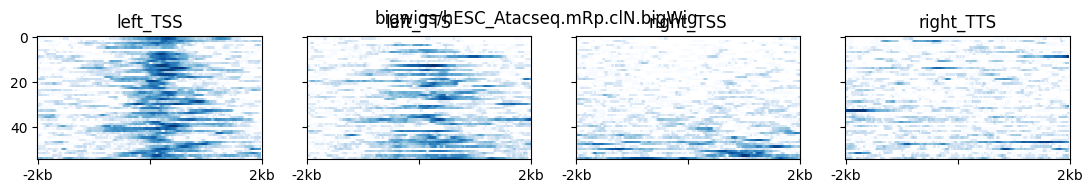

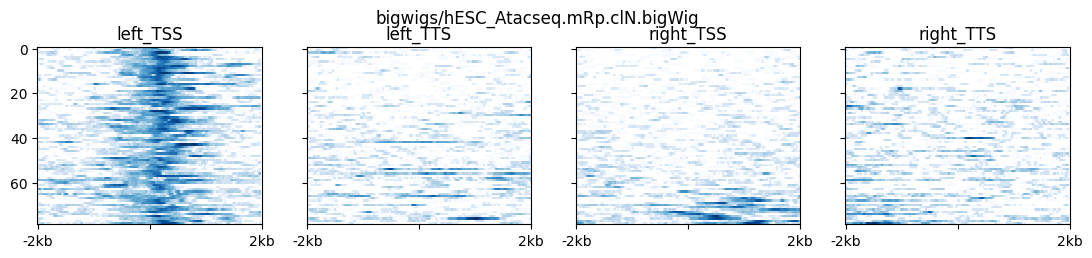

In [389]:
bw_fname  = "bigwigs/hESC_Atacseq.mRp.clN.bigWig"

strand="+"

_left,_right = get_left_right_gene(pita_esc, strand)

# PITA
###########################################
stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["right_TSS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)

# ctrl
###########################################

_left,_right = get_left_right_gene(ctrl_esc, strand)

stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["right_TSS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)



strand="-"

_left,_right = get_left_right_gene(pita_esc, strand)

# PITA
###########################################
stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["right_TSS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)

# ctrl
###########################################

_left,_right = get_left_right_gene(ctrl_esc, strand)

stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["right_TSS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)

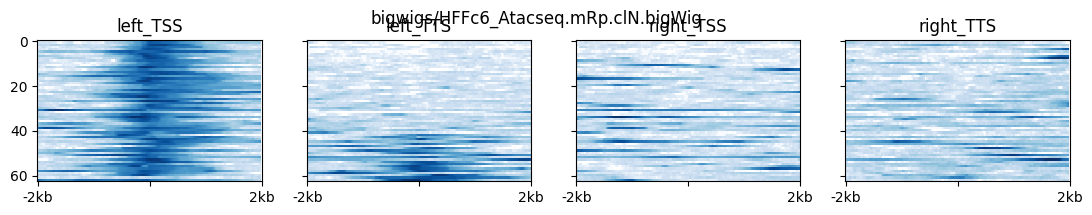

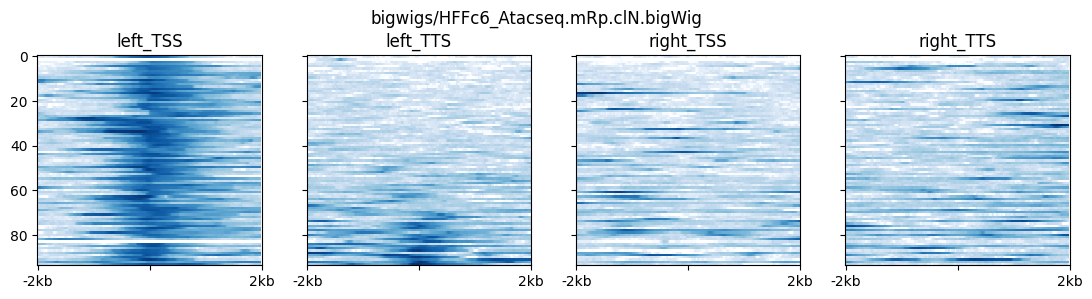

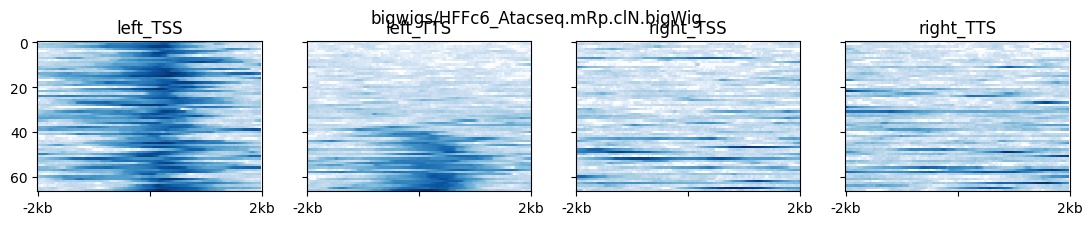

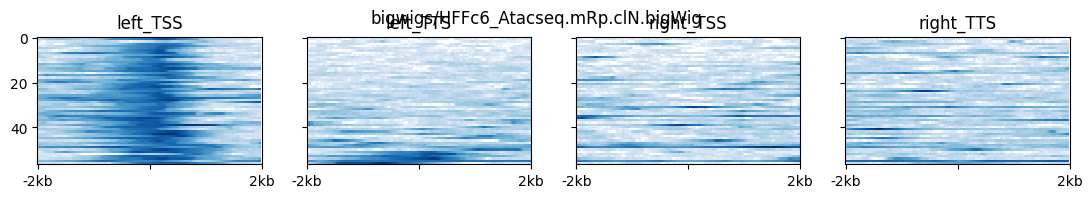

In [384]:
bw_fname  = "bigwigs/HFFc6_Atacseq.mRp.clN.bigWig"
# bw_fname = "bigwigs/hESC_Atacseq.mRp.clN.bigWig"
ctrl
strand="+"
# PITA...
###############################################
_left,_right = get_left_right_gene(pita_hff, strand)

stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["left_TTS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)


# Ctrl...
###########################################################

_left,_right = get_left_right_gene(ctrl_hff, strand)

stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["left_TTS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)



strand="-"
# PITA...
###############################################
_left,_right = get_left_right_gene(pita_hff, strand)

stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["left_TTS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)


# Ctrl...
###########################################################

_left,_right = get_left_right_gene(ctrl_hff, strand)

stackups = get_tss_tts_stacks(bw_fname, _left, _right, flank=_flank, nbins=_nbins)
# extract order
idx = np.argsort(stackups["left_TTS"].sum(axis=1))
show_stacks(stackups, order_idx=idx, flank=_flank, nbins=_nbins)

In [154]:
import numpy as np

In [187]:
_num = 10
# _num = 10
ttt = np.random.rand(_num*_num, 100, 100)
for i in range(_num*_num):
    ttt[i] = ttt[i]+i/100.

30
28
26
24
22
20
18
16
14
12
37
34
31
28
25
22
19
16
13
42
38
34
30
26
22
18
14
45
40
35
30
25
20
15
46
40
34
28
22
16
45
38
31
24
17
42
34
26
18
37
28
19
30
20
21


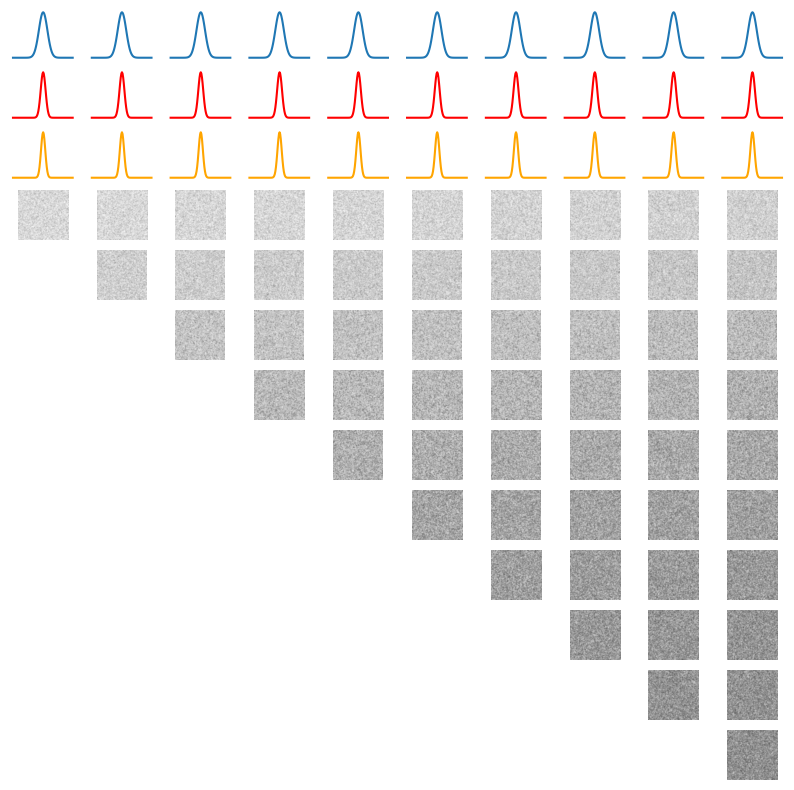

In [240]:
_extra_rows = 3

f,axs = plt.subplots(
    nrows=_num+_extra_rows,
    ncols=_num,
    figsize=(10,10)
)

index = 0
for i in range(_num+_extra_rows):
    for j in range(_num):
        axs[i,j].axis("off")
        if i == 0:
            axs[i,j].plot(np.arange(100), np.exp(-(np.arange(100)-50)**2/100)  )
        if i == 1:
            axs[i,j].plot(np.arange(100), np.exp(-(np.arange(100)-50)**2/33), color="red" )
        if i == 2:
            axs[i,j].plot(np.arange(100), np.exp(-(np.arange(100)-50)**2/25), color="orange" )
        #
        #
        # axs[i,j].set_xticks([])
        # axs[i,j].set_yticks([])
        # axs[i,j].set_xticklabels([])
        # axs[i,j].set_yticklabels([])
        if (j >= i - (_extra_rows))&(i>=_extra_rows):
            # print(i,j)
            axs[ i, j ].imshow(
                # ttt[ i*(_num - j) + j ],
                ttt[ index ],
                cmap="Greys",
                interpolation="gaussian",
                vmin=0,
                vmax=2,
            )
            index += 1
            print(i*(_num - j) + j)
        #
        #
        # if j < i:
        #     axs[i,j].axis("off")